In [1]:
import time, math
from torchsummary import summary
from torchtsmixer.tsmixer import TSMixer
import torch.optim as optim
from sklearn.metrics import mean_absolute_percentage_error, r2_score, mean_squared_error, mean_absolute_error
import pandas as pd
import gc
from sklearn.preprocessing import MinMaxScaler
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

hist_step = 100
pred_step = 1
input_channel = 3
output_channel = 6

model = TSMixer(hist_step, pred_step, input_channel, output_channel, dropout_rate = 0.32, ff_dim = 128, num_blocks = 4)
model = model.to(device=device)

cuda


In [2]:
import os
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

current_dir = os.getcwd()

parent_dir = os.path.dirname(current_dir)
data_dir = os.path.join(parent_dir, "TestSet")
print(f"Data directory: {data_dir}")

scaler_dir = os.path.join(current_dir, "Scaler")
print(f"Scaler directory: {scaler_dir}")

X_seq_test = np.load(os.path.join(data_dir, "X_seq_test.npy"))
X_static_test = np.load(os.path.join(data_dir, "X_static_test.npy"))
Y_test = np.load(os.path.join(data_dir, "Y_test.npy"))

print("Test set:", X_seq_test.shape, X_static_test.shape, Y_test.shape)

def load_minmax_scaler(path):
    data = np.load(path)
    return data["min_val"], data["max_val"]

X_seq_min, X_seq_max = load_minmax_scaler(
    os.path.join(scaler_dir, "X_seq_minmax_scaler.npz")
)
X_static_min, X_static_max = load_minmax_scaler(
    os.path.join(scaler_dir, "X_static_minmax_scaler.npz")
)
Y_min, Y_max = load_minmax_scaler(
    os.path.join(scaler_dir, "Y_static_minmax_scaler.npz")
)

def apply_minmax(x, min_val, max_val):
    return (x - min_val) / (max_val - min_val + 1e-8)

X_seq_test_flat = X_seq_test.reshape(-1, X_seq_test.shape[-1])
X_seq_test_norm = apply_minmax(X_seq_test_flat, X_seq_min, X_seq_max)
X_seq_test_norm = X_seq_test_norm.reshape(X_seq_test.shape)

X_static_test_norm = apply_minmax(X_static_test, X_static_min, X_static_max)
Y_test_norm = apply_minmax(Y_test, Y_min, Y_max)

case_dir = os.path.join(data_dir, "test_cases")
test_data_per_case = {}

if not os.path.isdir(case_dir):
    raise FileNotFoundError(f"Test condition catalog not found: {case_dir}")

case_ids = []
for fn in os.listdir(case_dir):
    if fn.startswith("X_seq_case") and fn.endswith(".npy"):
        cid = int(fn.replace("X_seq_case", "").replace(".npy", ""))
        case_ids.append(cid)
case_ids = sorted(case_ids)

for cid in case_ids:
    X_seq_case = np.load(os.path.join(case_dir, f"X_seq_case{cid}.npy"))
    X_static_case = np.load(os.path.join(case_dir, f"X_static_case{cid}.npy"))
    Y_case = np.load(os.path.join(case_dir, f"Y_case{cid}.npy"))

    test_data_per_case[cid] = (X_seq_case, X_static_case, Y_case)

print(f"✅ test_data_per_case : {len(test_data_per_case)} test case")

test_data_per_case_norm = {}

for cid, (X_seq_case, X_static_case, Y_case) in test_data_per_case.items():

    X_seq_flat = X_seq_case.reshape(-1, X_seq_case.shape[-1])
    X_seq_case_norm = apply_minmax(X_seq_flat, X_seq_min, X_seq_max)
    X_seq_case_norm = X_seq_case_norm.reshape(X_seq_case.shape)

    X_static_case_norm = apply_minmax(X_static_case, X_static_min, X_static_max)
    Y_case_norm = apply_minmax(Y_case, Y_min, Y_max)

    X_seq_case_norm = X_seq_case_norm.reshape(-1, 100, 2)
    X_static_case_norm = X_static_case_norm.reshape(-1, 1)

    X_case_norm = torch.cat(
        [
            torch.tensor(X_seq_case_norm, dtype=torch.float32),
            torch.tensor(X_static_case_norm, dtype=torch.float32)
            .unsqueeze(1)
            .expand(-1, 100, -1),
        ],
        dim=-1,
    )

    test_data_per_case_norm[cid] = (X_case_norm, Y_case_norm)

print("✅ test_data_per_case_norm established")

X_seq_test_t = torch.tensor(X_seq_test_norm, dtype=torch.float32)
X_static_test_t = torch.tensor(X_static_test_norm, dtype=torch.float32)
Y_test_t = torch.tensor(Y_test_norm, dtype=torch.float32)

test_X = torch.cat(
    [X_seq_test_t, X_static_test_t.unsqueeze(1).expand(-1, 100, -1)],
    dim=-1,
)

test_dataset = TensorDataset(test_X, Y_test_t)

batch_size = 256
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
)

Data directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\TestSet
Scaler directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\2_CTFT_TSMixer_GR\Scaler
Test set: (13006, 100, 2) (13006, 1) (13006, 6)
✅ test_data_per_case : 9 test case
✅ test_data_per_case_norm established


In [3]:
Y_min_t = torch.tensor(Y_min, dtype=torch.float32, device=device)  
Y_max_t = torch.tensor(Y_max, dtype=torch.float32, device=device)  
Y_range_t = (Y_max_t - Y_min_t).clamp_min(1e-8)                   

In [4]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

current_dir = os.getcwd()
data_dir = os.path.join(current_dir, "Best_TSMixer.pth")  
print(f"Data directory: {data_dir}")

best_model = torch.load(data_dir, weights_only = False)

Data directory: d:\0DATA\NHRI\Python Code\4、代理模型_水深预测\GitHub\上传 - 1.5\2_CTFT_TSMixer_GR\Best_TSMixer.pth


In [5]:
print(model)

TSMixer(
  (mixer_layers): Sequential(
    (0): MixerLayer(
      (time_mixing): TimeMixing(
        (norm): TimeBatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.32, inplace=False)
        (fc1): Linear(in_features=100, out_features=100, bias=True)
      )
      (feature_mixing): FeatureMixing(
        (norm_before): TimeBatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm_after): Identity()
        (dropout): Dropout(p=0.32, inplace=False)
        (fc1): Linear(in_features=3, out_features=128, bias=True)
        (fc2): Linear(in_features=128, out_features=3, bias=True)
        (projection): Identity()
      )
    )
    (1): MixerLayer(
      (time_mixing): TimeMixing(
        (norm): TimeBatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.32, inplace=False)
        (fc1): Linear(in_features=100, out_features=100, bias=True

In [6]:
import numpy as np

def median_absolute_error(y_true, y_pred):
    """
    Median Absolute Error (MdAE)
    """
    errors = np.abs(y_true - y_pred)
    return np.median(errors)

def iqr_based_mae(y_true, y_pred):
    errors = np.abs(y_true - y_pred).flatten()  # 拉平成一维
    q1 = np.percentile(errors, 25)
    q3 = np.percentile(errors, 75)
    mask = (errors >= q1) & (errors <= q3)
    filtered_errors = errors[mask]
    if len(filtered_errors) == 0:
        return np.nan  # 没有有效样本
    return np.mean(filtered_errors)


def NSE_global(y_true, y_pred, eps=1e-12):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    num = np.sum((y_true - y_pred) ** 2)
    den = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1.0 - num / (den + eps)


def R2_global(y_true, y_pred, eps=1e-12):
    return NSE_global(y_true, y_pred, eps=eps)


def NSE(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)


def hit_rate(y_true, y_pred, delta):
    relative_errors = np.abs((y_pred - y_true) / y_true) * 100  # 相对误差 (%)
    hits = relative_errors <= delta
    return np.mean(hits) * 100  

def KGE(y_true, y_pred):
    """Kling–Gupta Efficiency"""
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    r = np.corrcoef(y_true, y_pred)[0, 1]
    beta = np.mean(y_pred) / np.mean(y_true)
    gamma = (np.std(y_pred) / np.mean(y_pred)) / (np.std(y_true) / np.mean(y_true))
    kge = 1 - np.sqrt((r - 1)**2 + (beta - 1)**2 + (gamma - 1)**2)
    return kge

def willmott_index_modified(observed, predicted):
    """
    Willmott's Modified Index of Agreement (Willmott et al., 2012)
    """
    observed = np.array(observed)
    predicted = np.array(predicted)
    
    numerator = np.sum(np.abs(predicted - observed))
    denominator = 2 * np.sum(np.abs(observed - np.mean(observed)))
    
    if denominator == 0:
        return 1.0 if numerator == 0 else 0.0
    
    d = 1 - (numerator / denominator)
    return np.clip(d, 0, 1)


max_delta=5
deltas = np.arange(0.25, max_delta+0.25, 0.25)  # δ = 1% ~ max_delta%
print(deltas)

def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true))
    r2 = R2_global(y_true, y_pred)
    nse = NSE_global(y_true, y_pred)  
    kge = KGE(y_true, y_pred)
    d_index = willmott_index_modified(y_true, y_pred)
    hr = [hit_rate(y_true, y_pred, d) for d in deltas]
    mdae = median_absolute_error(y_true, y_pred)
    iqr_mae = iqr_based_mae(y_true, y_pred)
    max_err = np.max(np.abs(y_true - y_pred))
    return {
        'MSE': mse, 'RMSE': rmse, 'MAPE': mape, 'MAE': mae,
        'R2': r2, 'NSE': nse, 'KGE': kge, 'd': d_index,
        'HitRate': hr, 'MdAE': mdae, 'IQR-based MAE': iqr_mae, 'MaxError': max_err
    }

[0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25 3.5
 3.75 4.   4.25 4.5  4.75 5.  ]


In [7]:
best_model = best_model.to(device)
best_model.eval()

def predict_norm(model, X_seq_norm, device):
    model.eval()
    X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)

    with torch.no_grad():
        out = model(X_seq_t)  
        out = out.squeeze(1)  
        return out.detach().cpu().numpy()

def denorm_y(y_norm, Y_min, Y_max):
    return y_norm * (Y_max - Y_min) + Y_min

print("\n===================== Test condition indicators (output first) =====================")

case_metrics = {} 

for cid in sorted(test_data_per_case_norm.keys()):
    X_case_norm, Y_case_norm = test_data_per_case_norm[cid]
 
    y_pred_case_norm = predict_norm(best_model, X_case_norm, device)
 
    y_pred_case_real = denorm_y(y_pred_case_norm, Y_min, Y_max)
    y_true_case_real = denorm_y(Y_case_norm, Y_min, Y_max)
 
    metrics_case = evaluate_metrics(y_true_case_real, y_pred_case_real)
    case_metrics[cid] = metrics_case
 
    print(f"\n--- Case {cid} ---")
    for k, v in metrics_case.items():
        if k != "HitRate":
            print(f"{k}: {v:.6f}")
        else:
            hr_str = ", ".join([f"{h:.2f}" for h in v])
            print(f"HitRate(δ=1~{max_delta}%): [{hr_str}]")

print("\n===================== The metrics for the entire test set (final output) =====================")
 
y_pred_total_norm = predict_norm(best_model, test_X, device)
 
y_pred_total_real = denorm_y(y_pred_total_norm, Y_min, Y_max)
y_true_total_real = denorm_y(Y_test_norm, Y_min, Y_max)

metrics_total = evaluate_metrics(y_true_total_real, y_pred_total_real)

print("\n--- Full test set overall ---")
for k, v in metrics_total.items():
    if k != "HitRate":
        print(f"{k}: {v:.6f}")
    else:
        hr_str = ", ".join([f"{h:.2f}" for h in v])
        print(f"HitRate(δ=1~{max_delta}%): [{hr_str}]")



===================== Test condition indicators (output first) =====================

--- Case 3 ---
MSE: 0.013745
RMSE: 0.117239
MAPE: 0.007871
MAE: 0.091313
R2: 0.627436
NSE: 0.627436
KGE: 0.818951
d: 0.704903
HitRate(δ=1~5%): [16.07, 41.07, 65.72, 76.35, 78.78, 81.23, 86.18, 90.77, 97.08, 99.90, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.067671
IQR-based MAE: 0.069253
MaxError: 0.289091

--- Case 6 ---
MSE: 0.008661
RMSE: 0.093065
MAPE: 0.005674
MAE: 0.081278
R2: 0.692221
NSE: 0.692221
KGE: 0.852910
d: 0.713636
HitRate(δ=1~5%): [14.68, 50.23, 71.46, 85.96, 99.36, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.071253
IQR-based MAE: 0.074977
MaxError: 0.192362


C:\Users\Administrator\AppData\Local\Temp\ipykernel_16444\621765218.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16444\621765218.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16444\621765218.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=t


--- Case 13 ---
MSE: 0.020977
RMSE: 0.144833
MAPE: 0.010767
MAE: 0.121966
R2: 0.555369
NSE: 0.555369
KGE: 0.833473
d: 0.667342
HitRate(δ=1~5%): [10.39, 25.56, 43.41, 50.90, 58.08, 68.21, 78.56, 87.30, 96.50, 99.39, 99.83, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.109289
IQR-based MAE: 0.113956
MaxError: 0.333477

--- Case 15 ---
MSE: 0.010374
RMSE: 0.101851
MAPE: 0.006796
MAE: 0.086757
R2: 0.613503
NSE: 0.613503
KGE: 0.736379
d: 0.691823
HitRate(δ=1~5%): [17.66, 40.42, 58.64, 74.25, 87.02, 98.12, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.079654
IQR-based MAE: 0.081695
MaxError: 0.208345

--- Case 22 ---
MSE: 0.004136
RMSE: 0.064308
MAPE: 0.004781
MAE: 0.054676
R2: 0.869957
NSE: 0.869957
KGE: 0.923763
d: 0.809183
HitRate(δ=1~5%): [28.75, 53.48, 77.09, 96.84, 99.96, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16444\621765218.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16444\621765218.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)
C:\Users\Administrator\AppData\Local\Temp\ipykernel_16444\621765218.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=t


--- Case 42 ---
MSE: 0.024002
RMSE: 0.154925
MAPE: 0.007866
MAE: 0.135279
R2: 0.543356
NSE: 0.543356
KGE: 0.764243
d: 0.636058
HitRate(δ=1~5%): [8.84, 35.87, 50.74, 64.73, 80.04, 96.00, 98.18, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.127336
IQR-based MAE: 0.129444
MaxError: 0.325888

===================== The metrics for the entire test set (final output) =====================


C:\Users\Administrator\AppData\Local\Temp\ipykernel_16444\621765218.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)



--- Full test set overall ---
MSE: 0.017714
RMSE: 0.133095
MAPE: 0.008063
MAE: 0.110585
R2: 0.995982
NSE: 0.995982
KGE: 0.993036
d: 0.969360
HitRate(δ=1~5%): [15.90, 35.38, 51.93, 67.48, 79.12, 87.68, 93.05, 96.92, 99.15, 99.88, 99.97, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00, 100.00]
MdAE: 0.096567
IQR-based MAE: 0.100411
MaxError: 0.333477


C:\Users\Administrator\AppData\Local\Temp\ipykernel_16444\621765218.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_seq_t = torch.tensor(X_seq_norm, dtype=torch.float32, device=device)


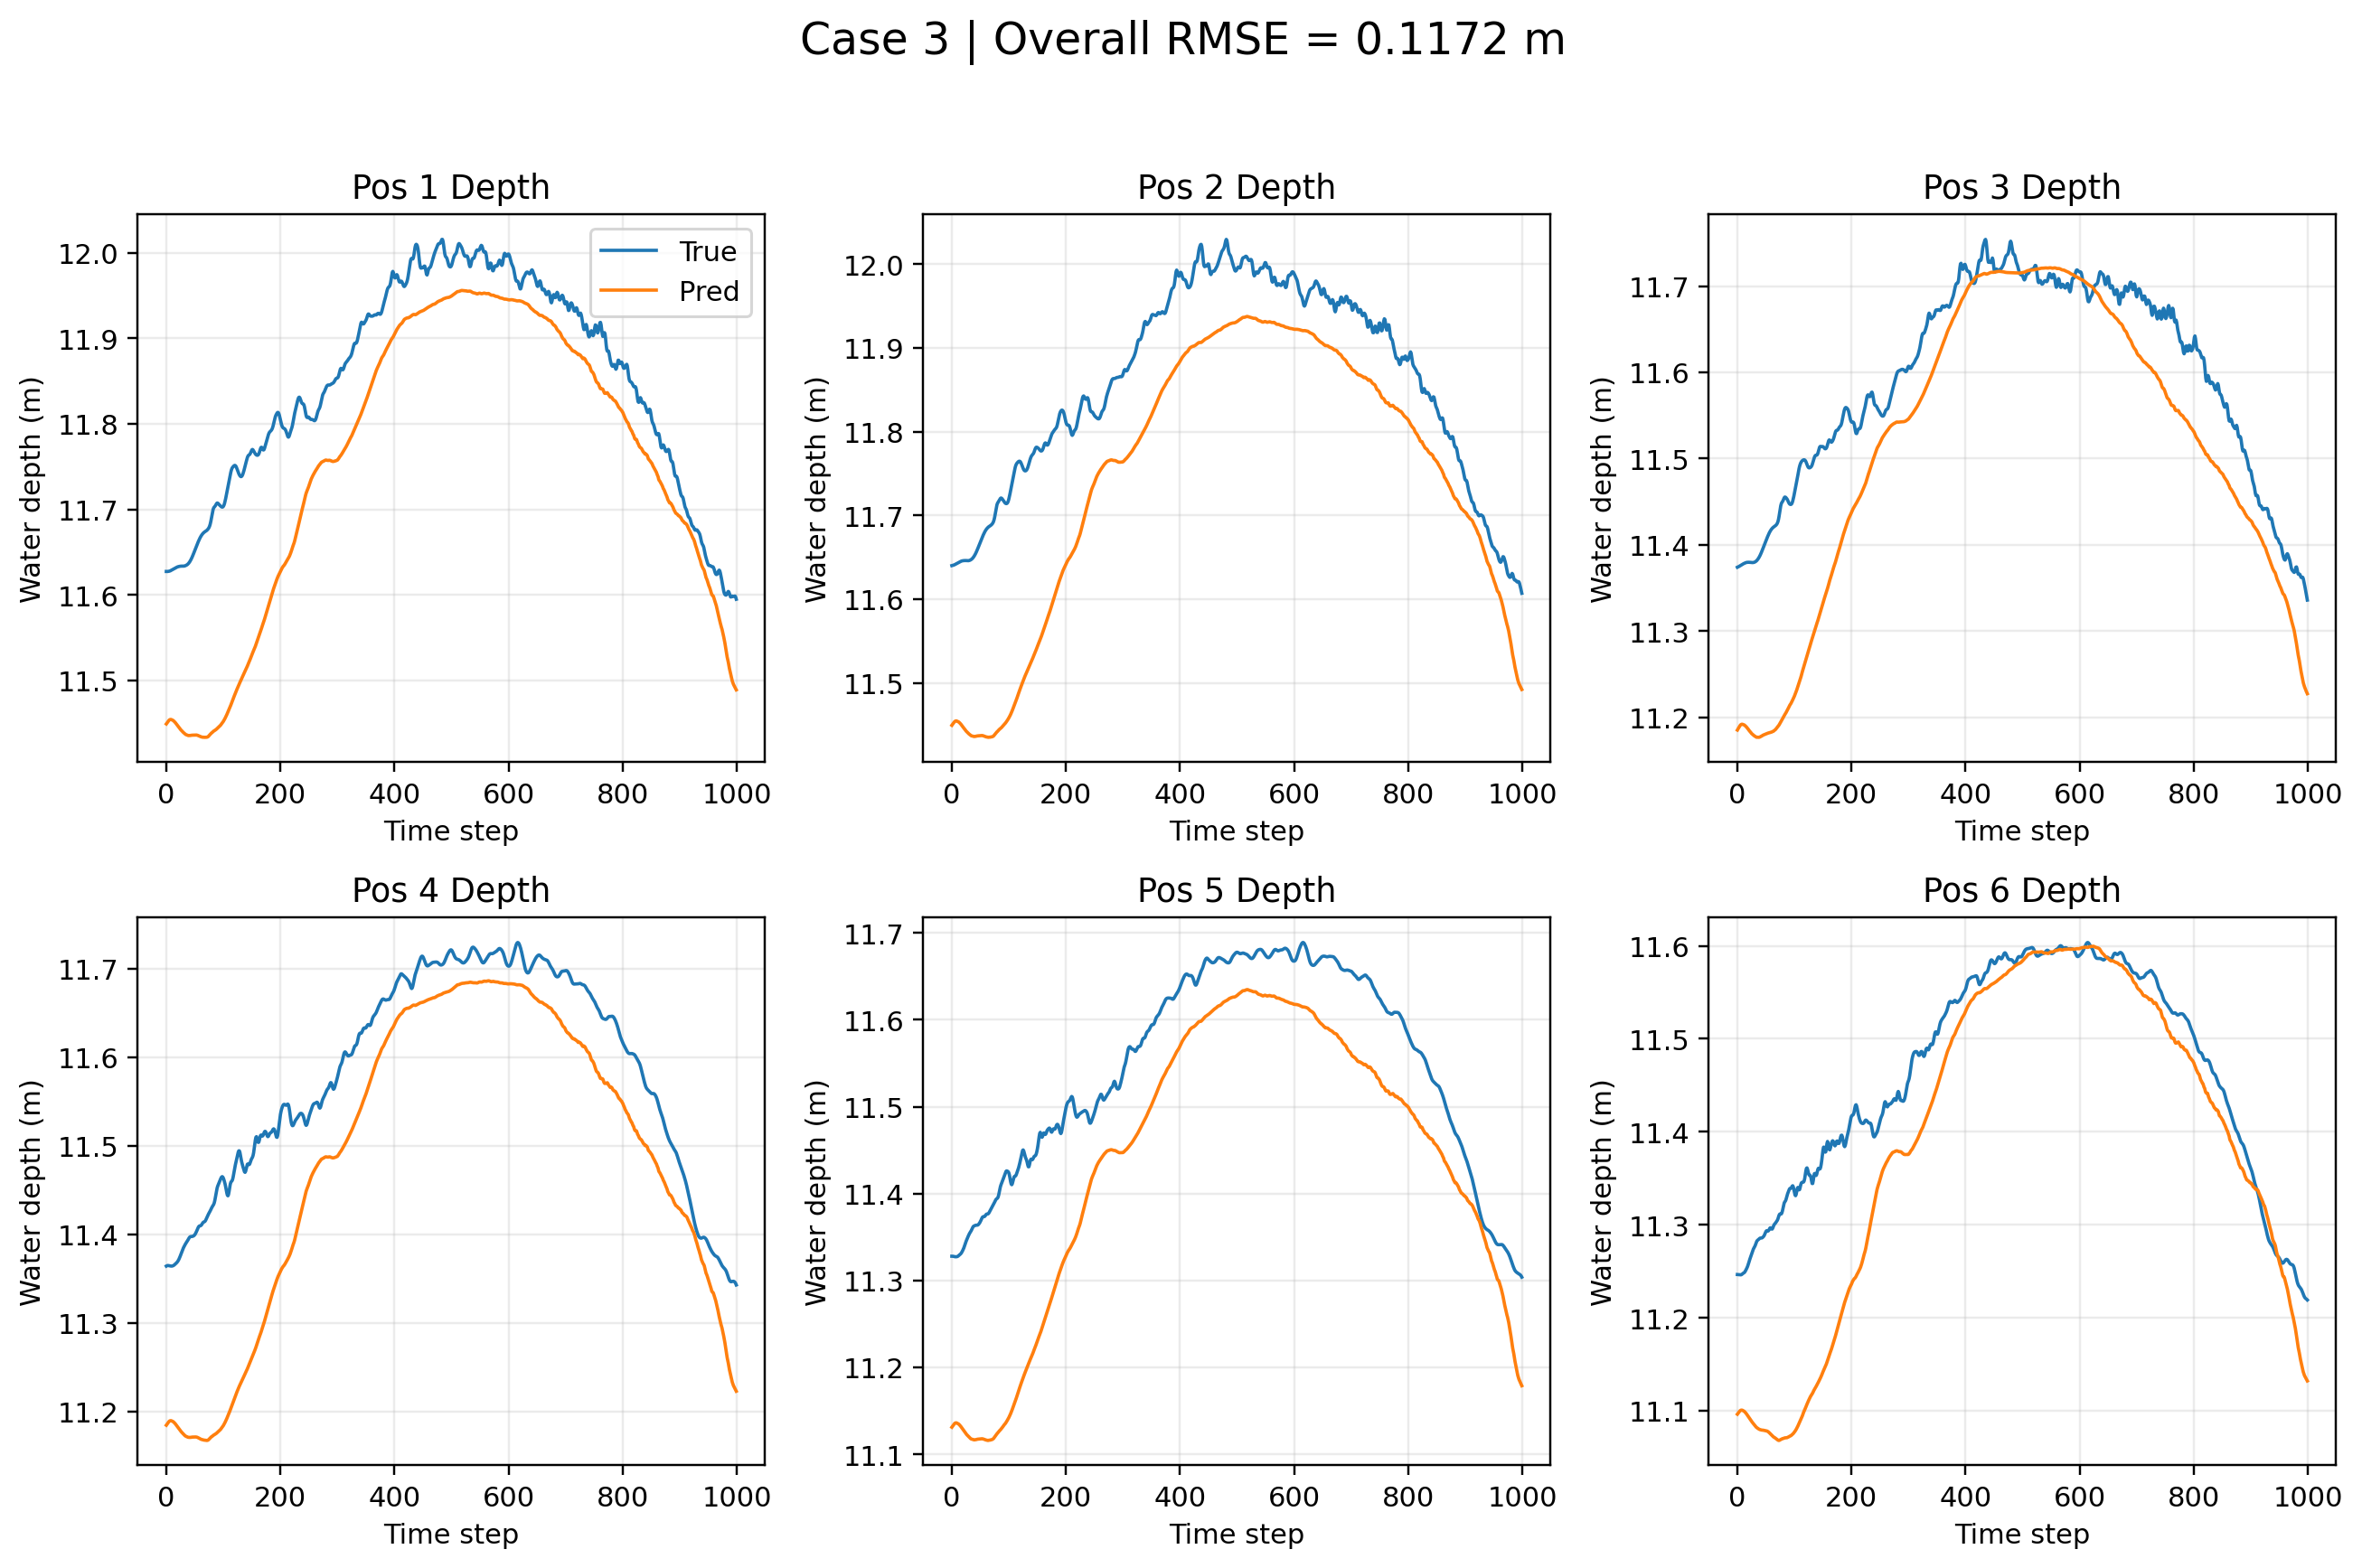

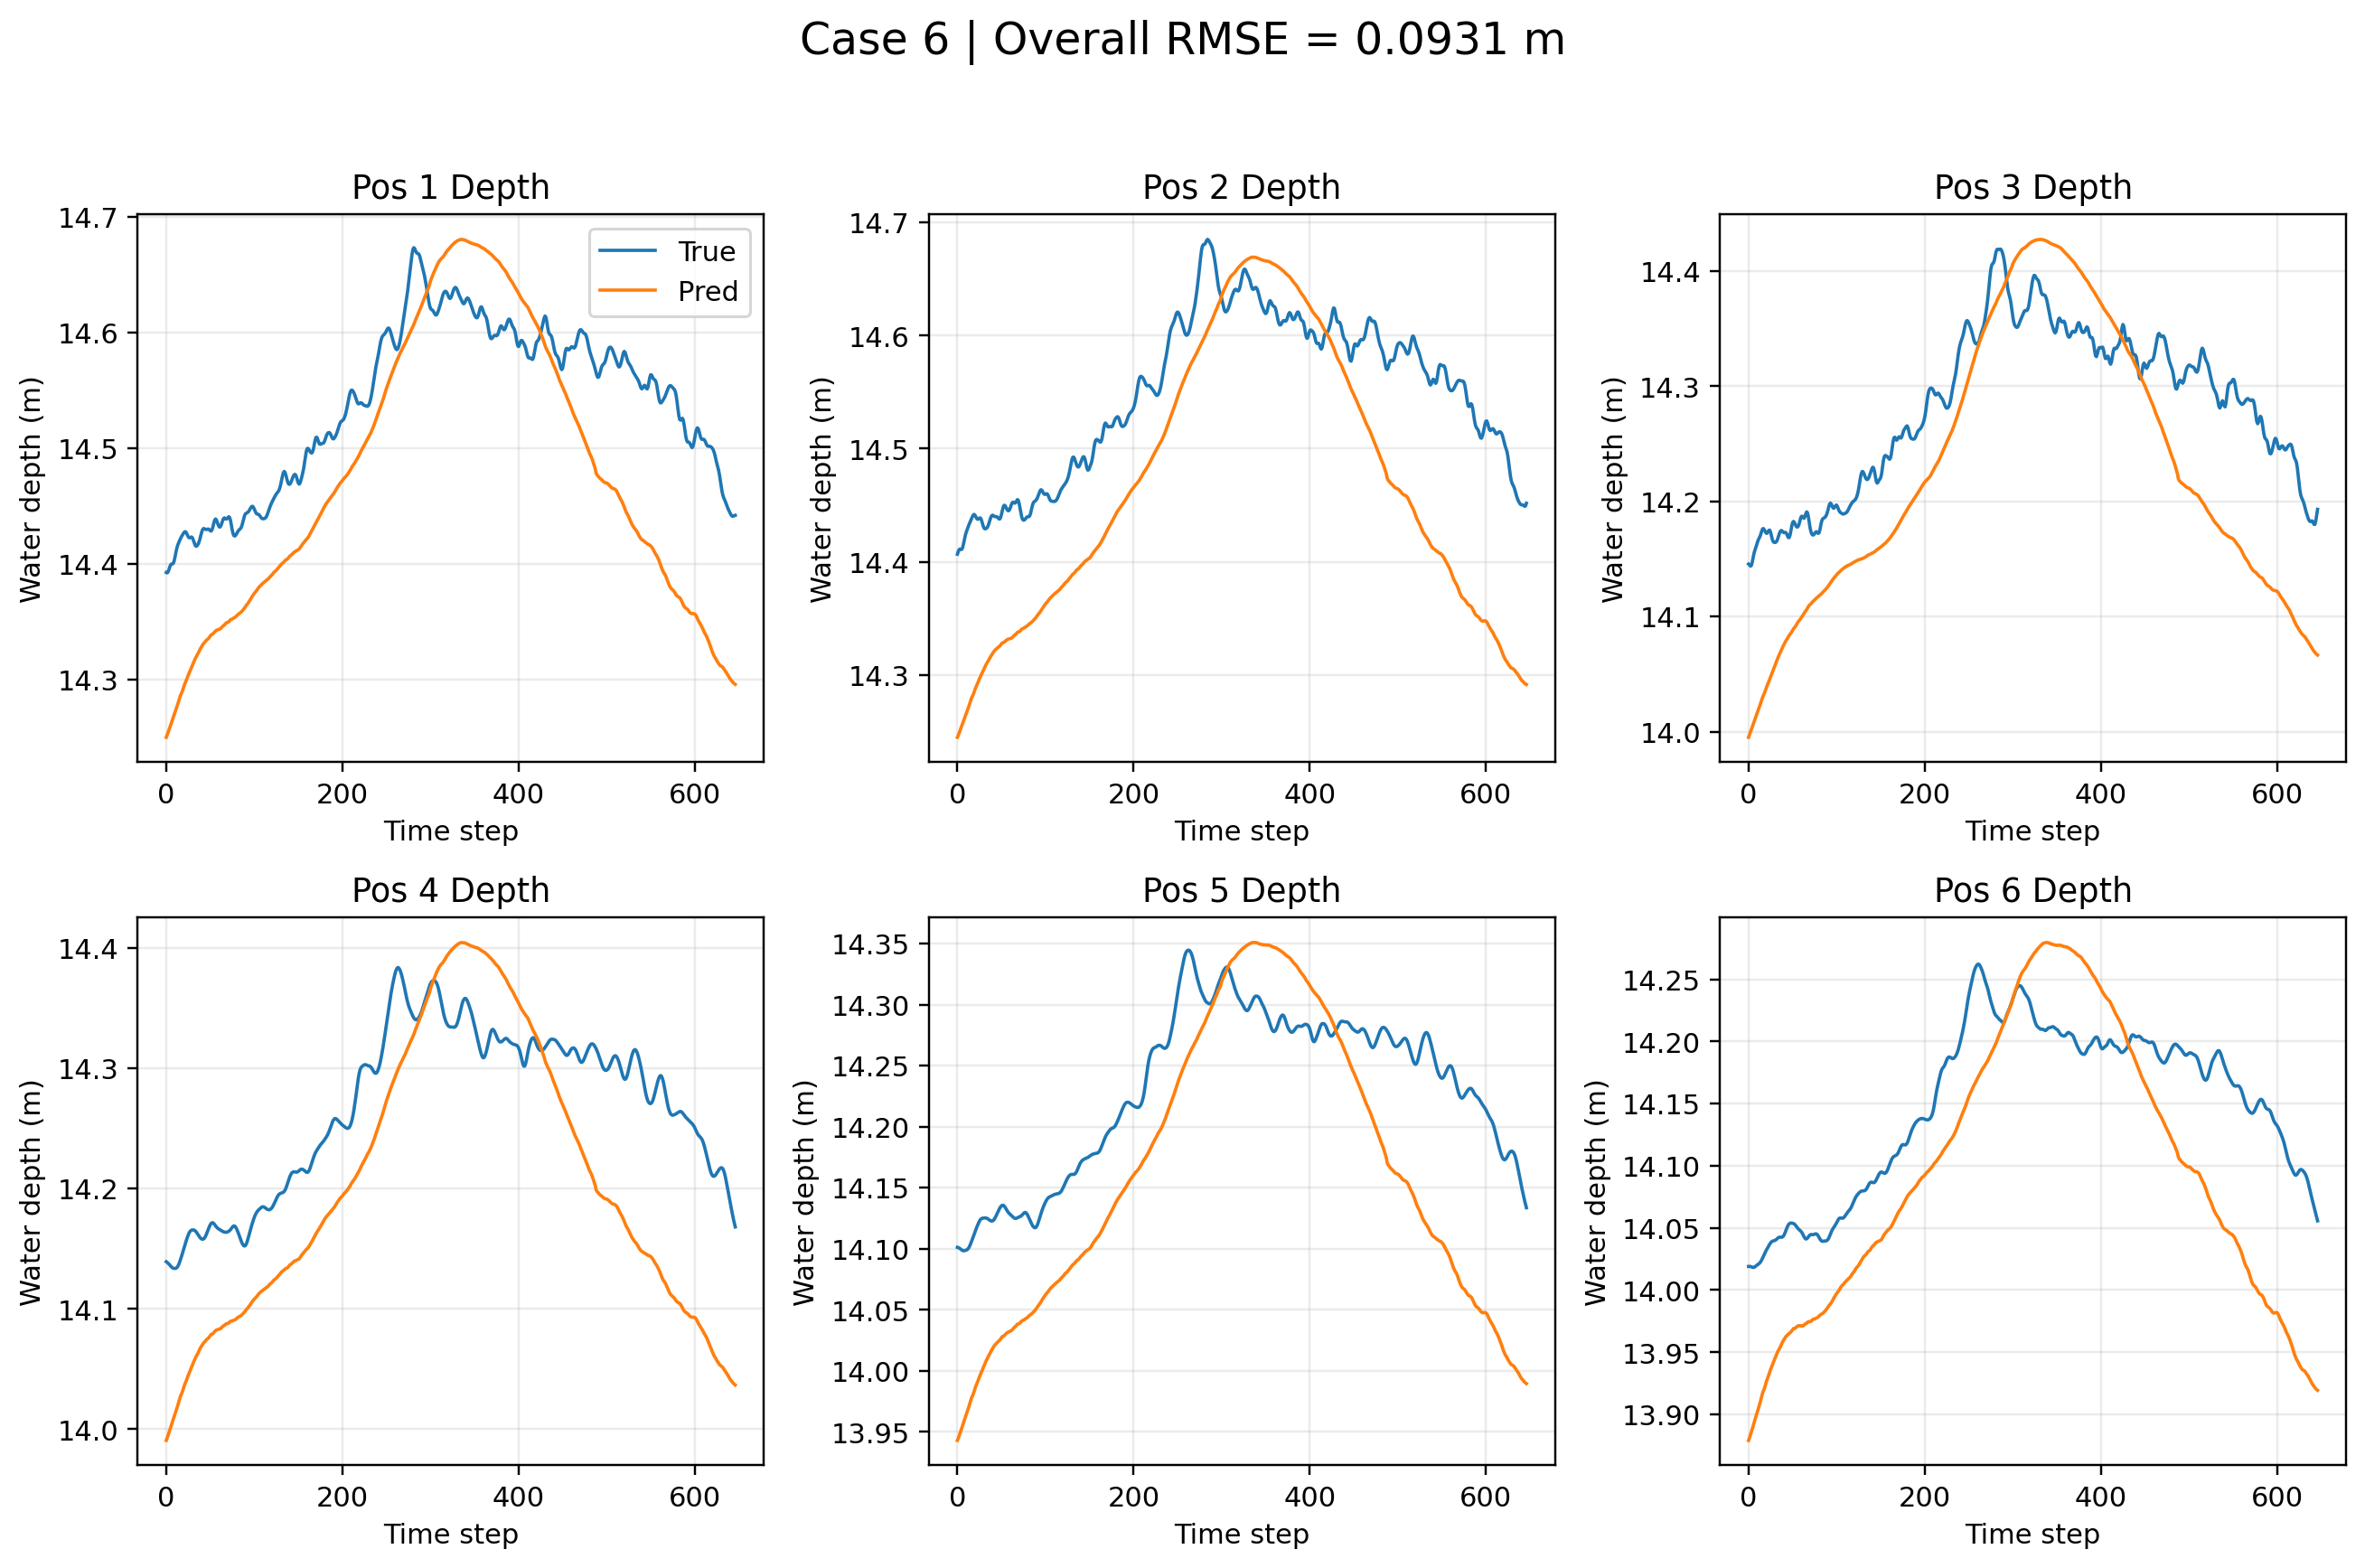

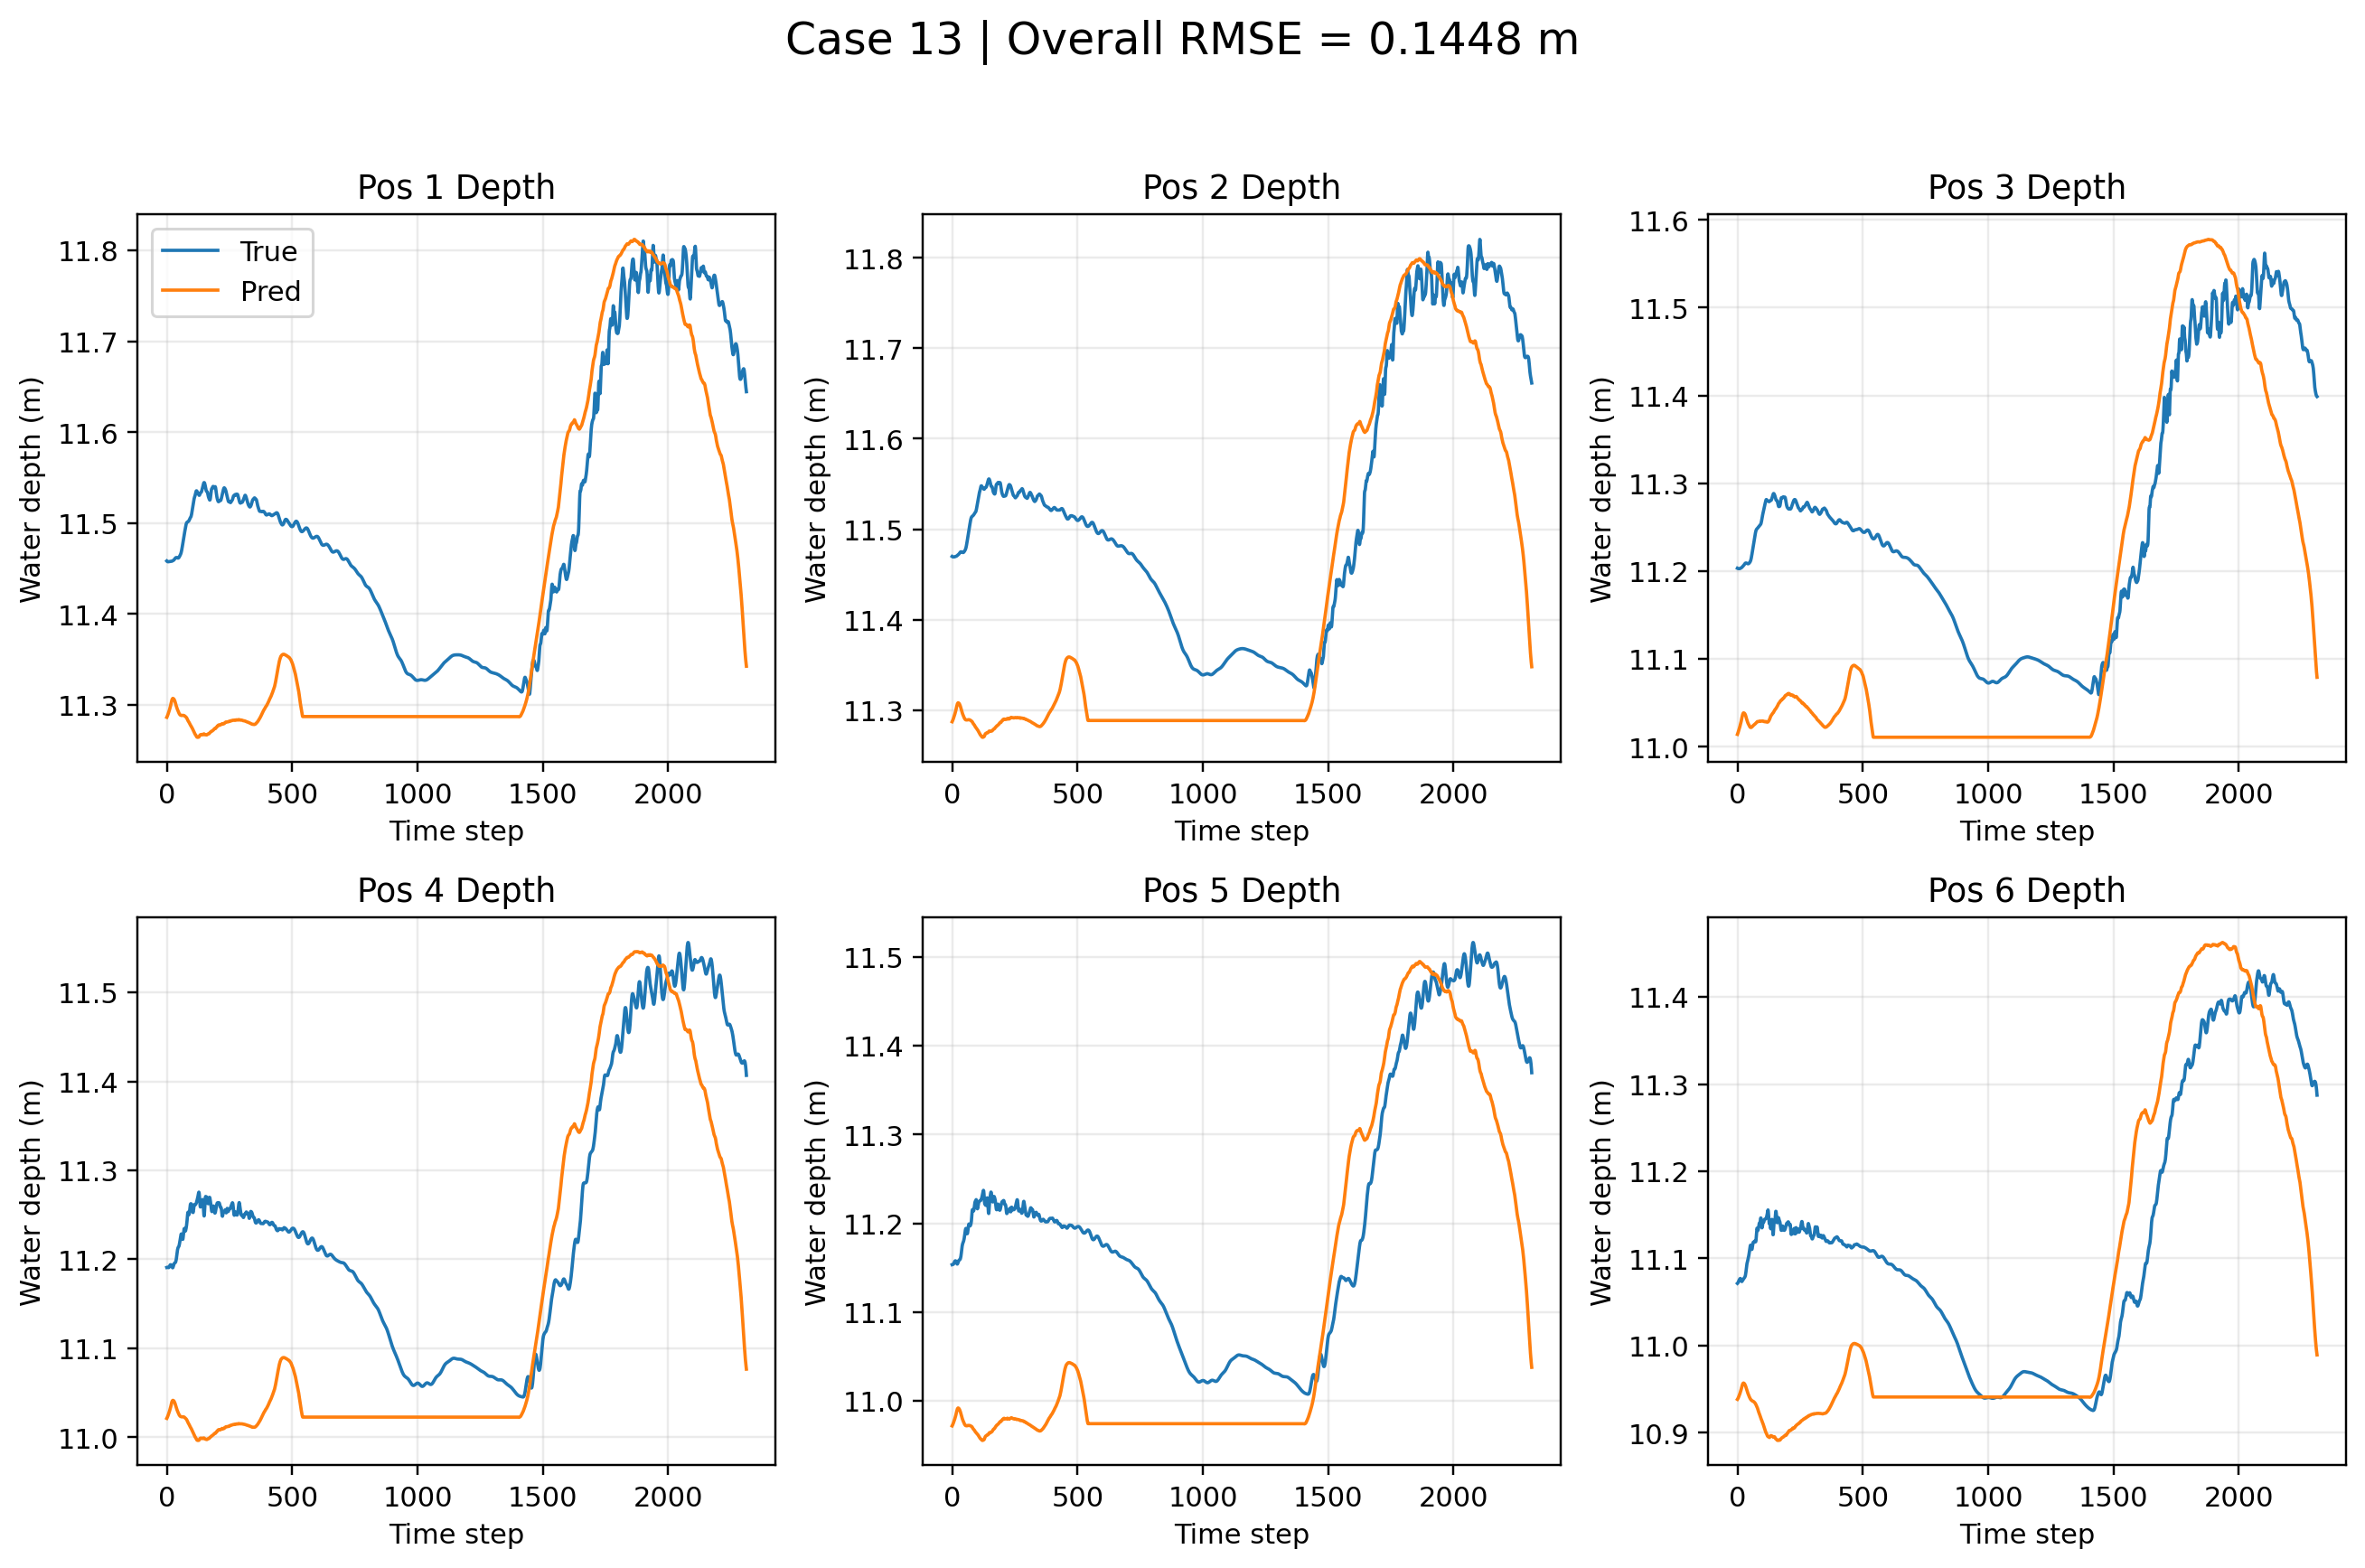

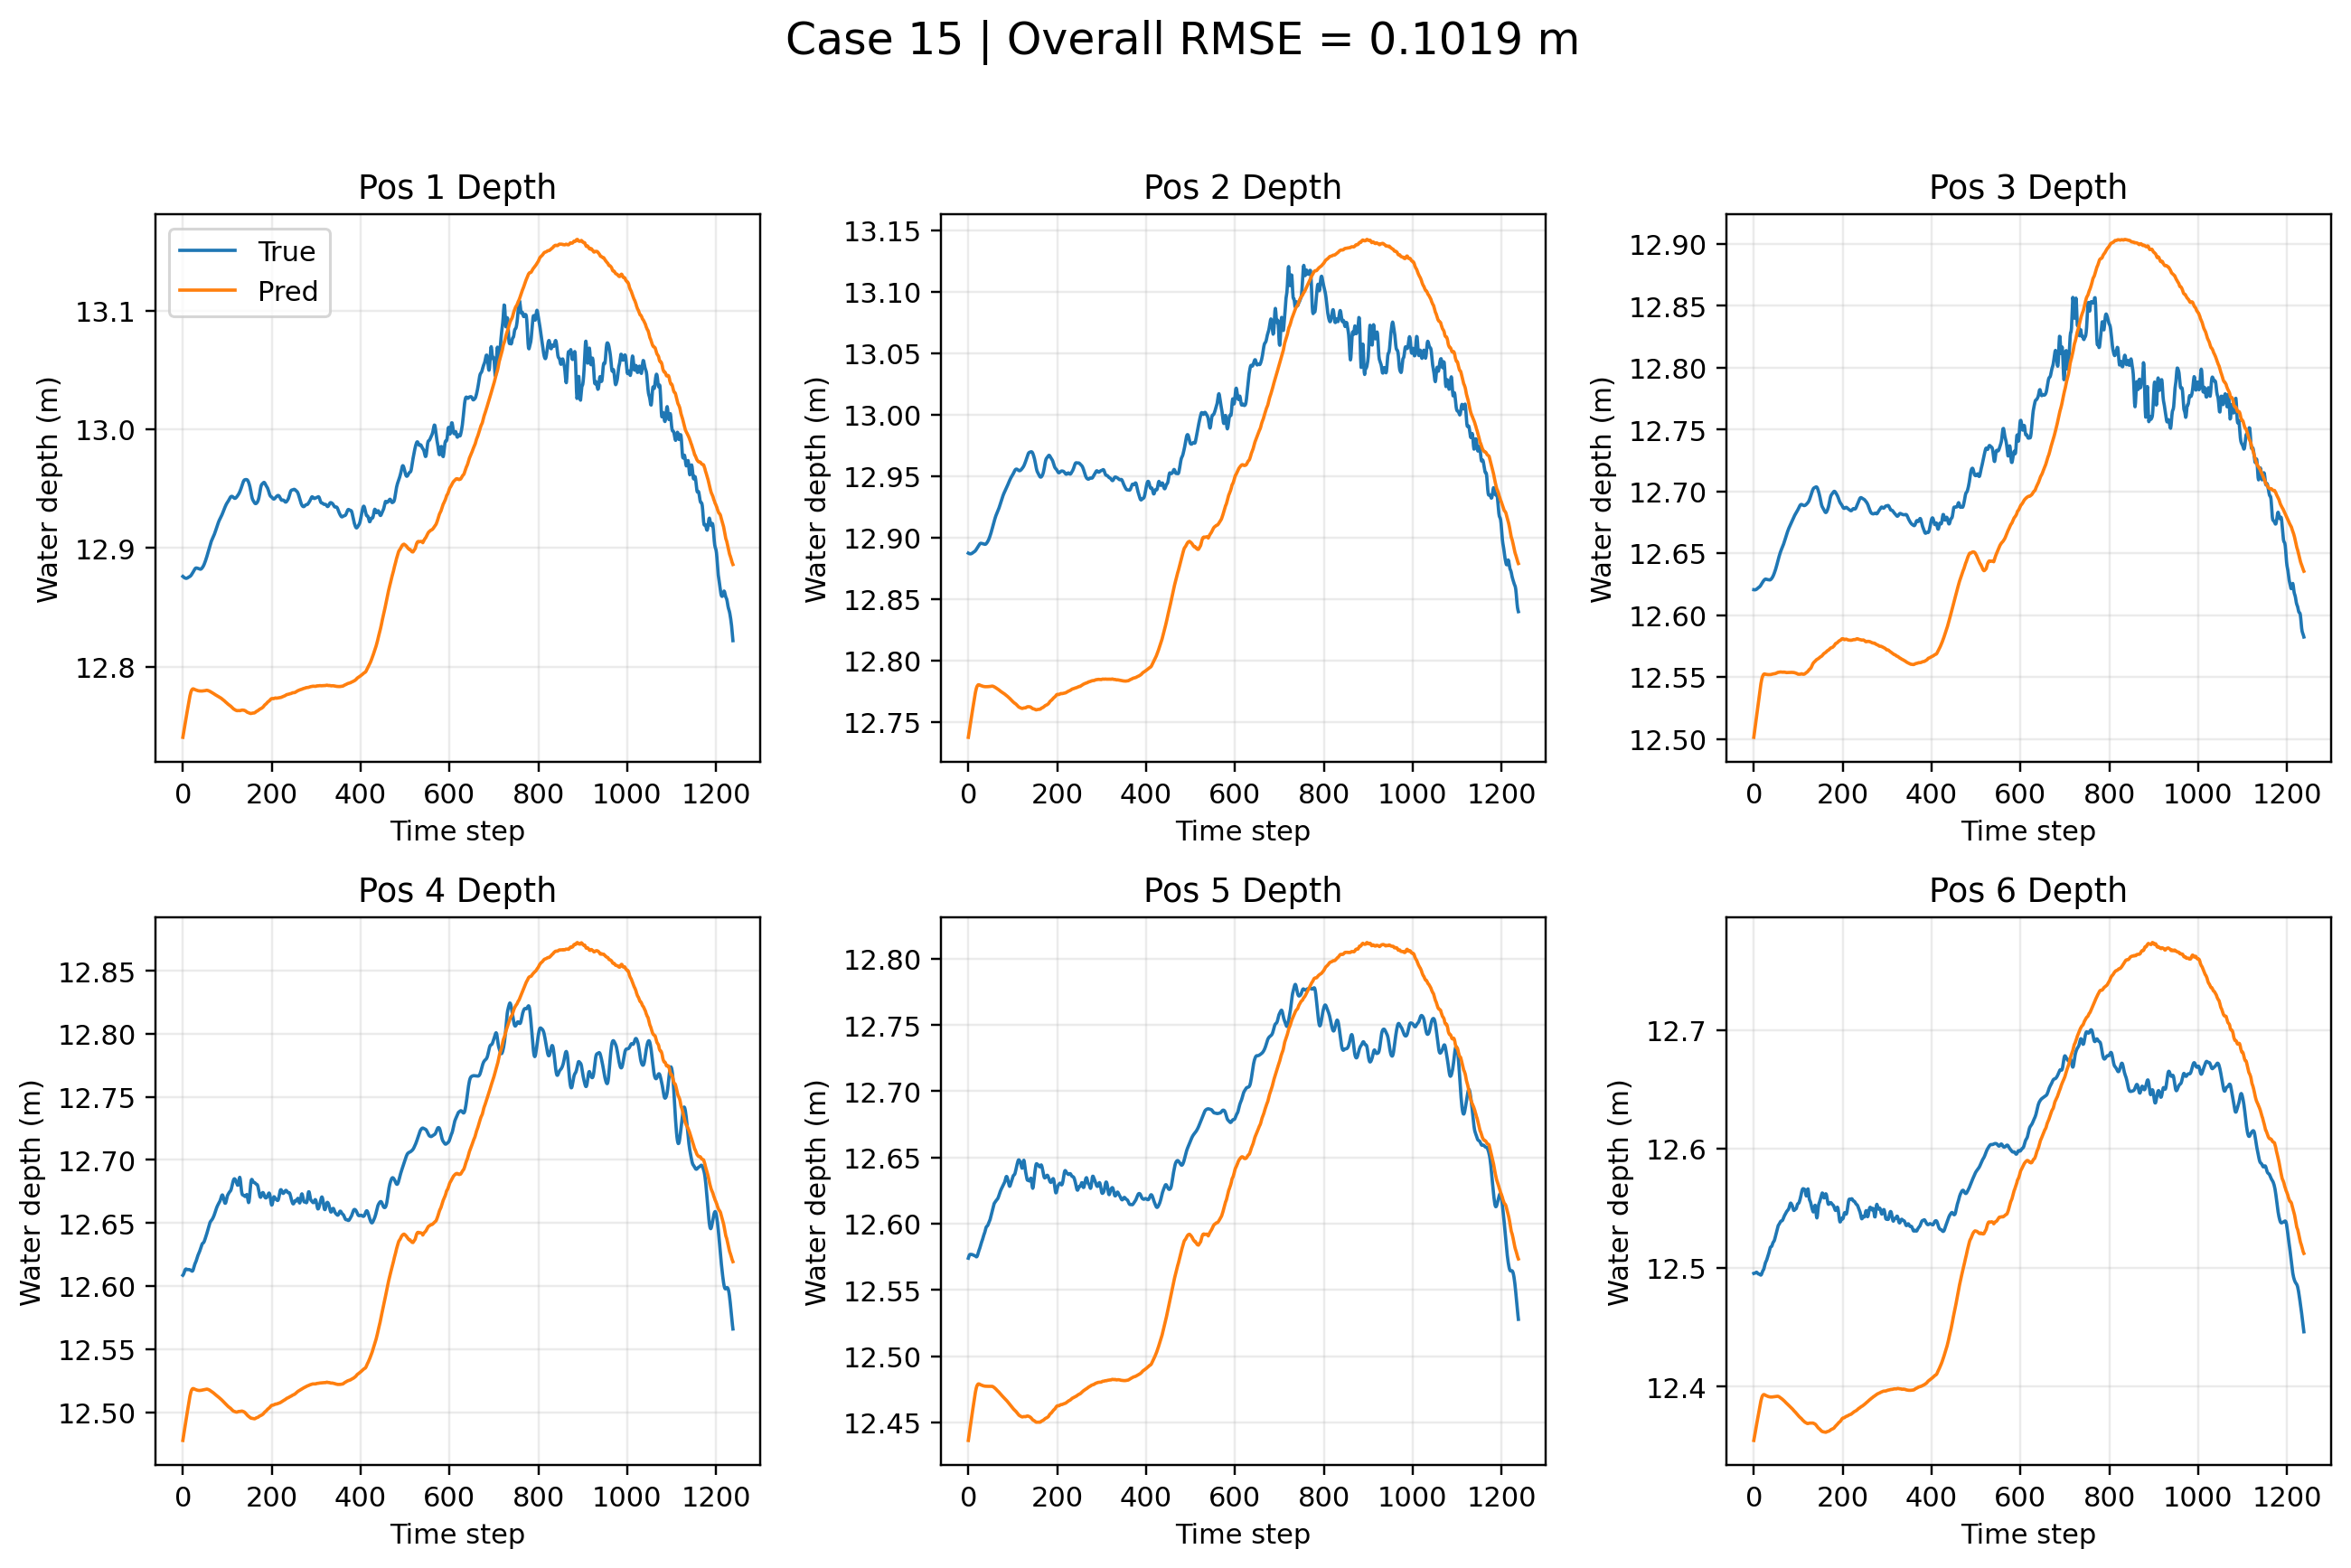

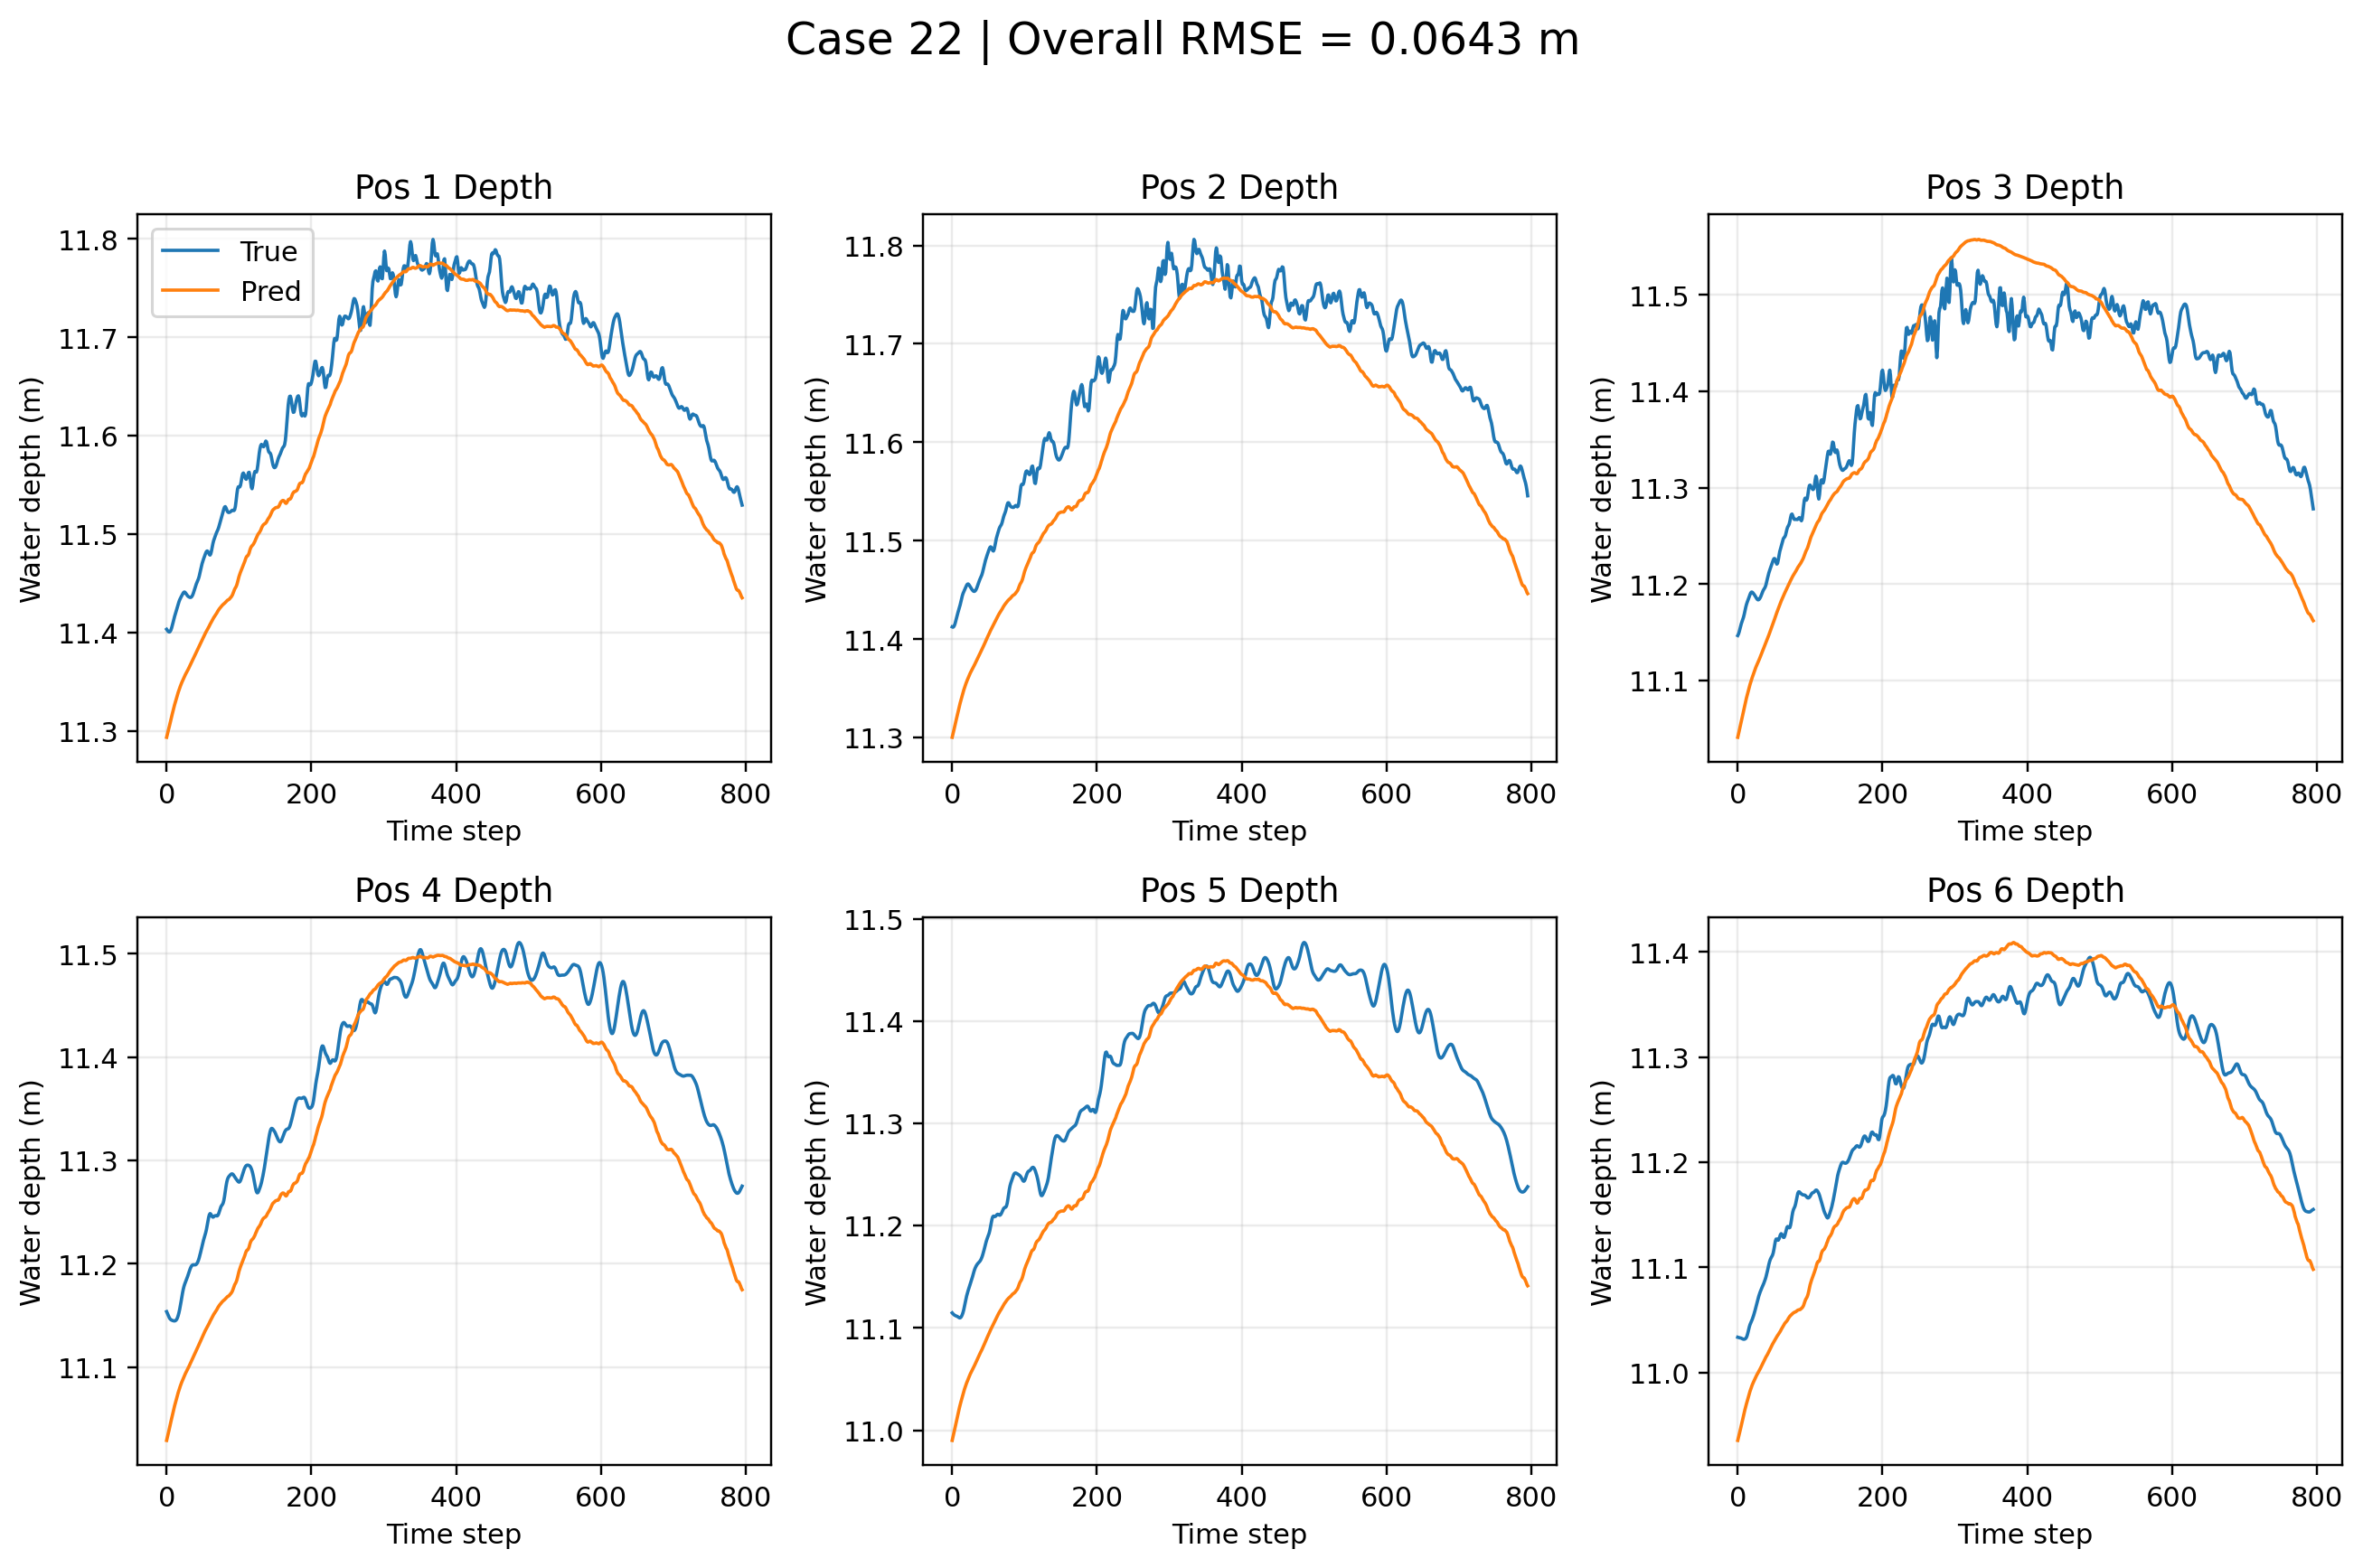

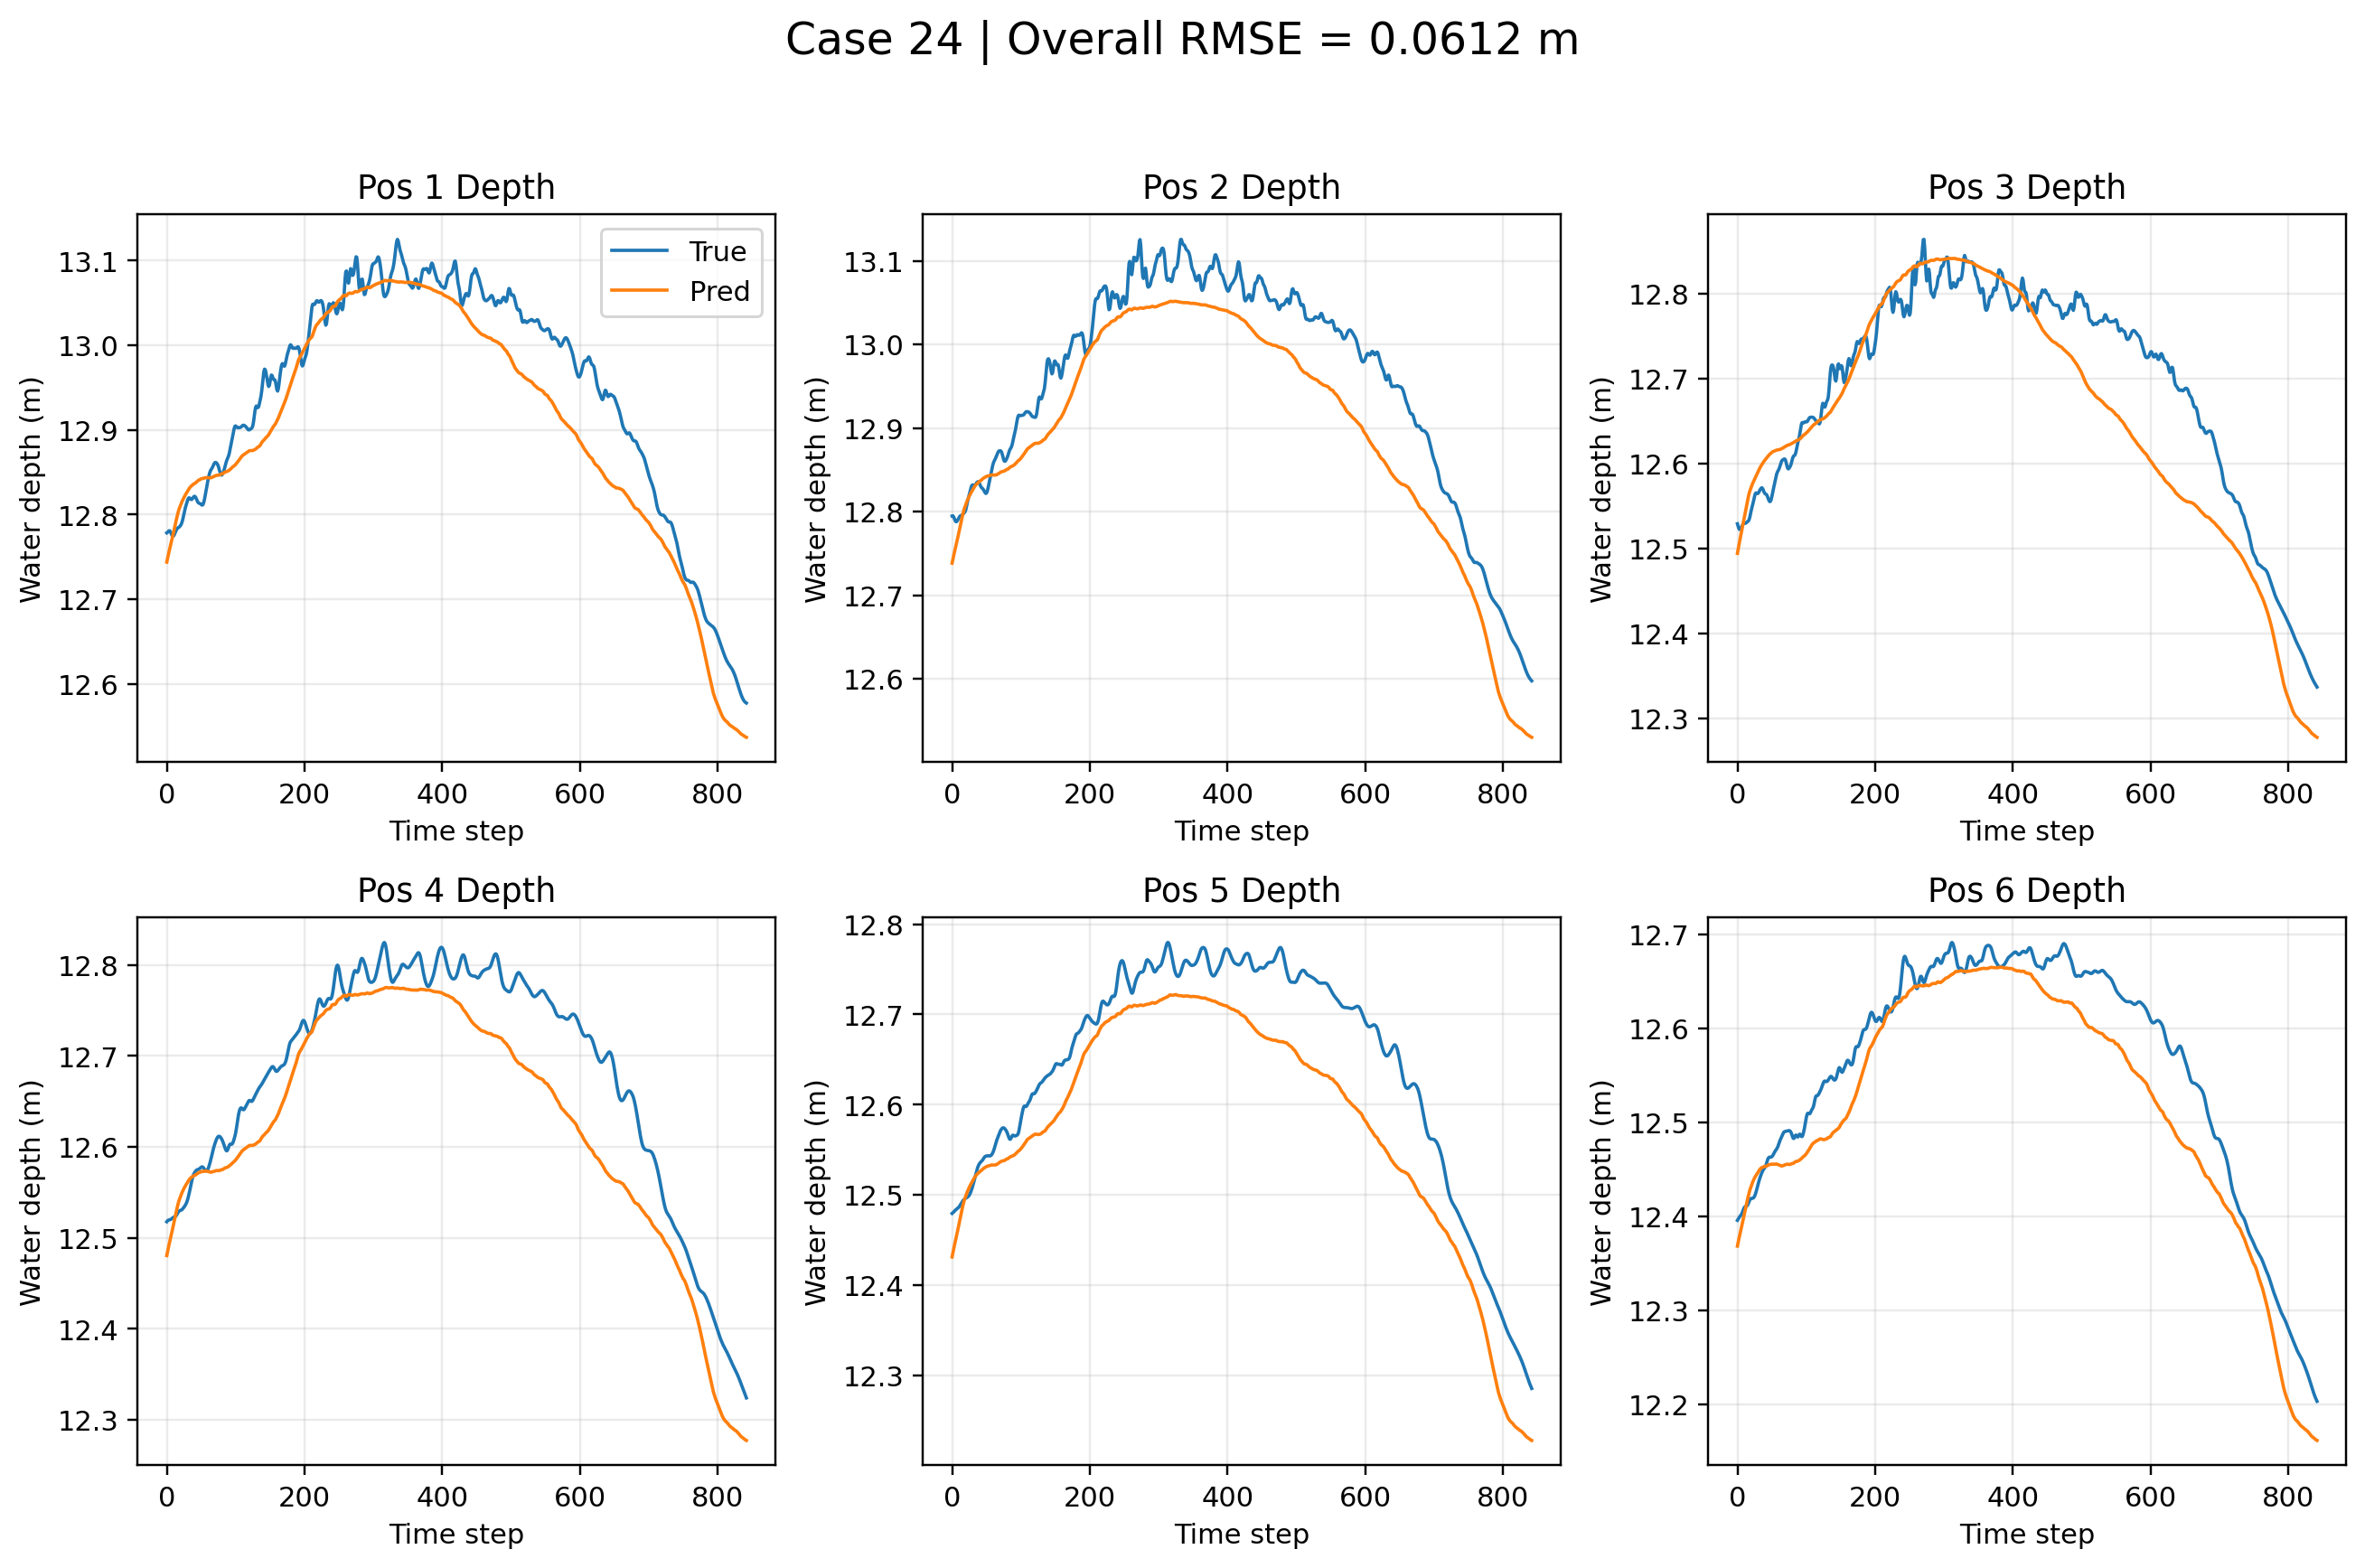

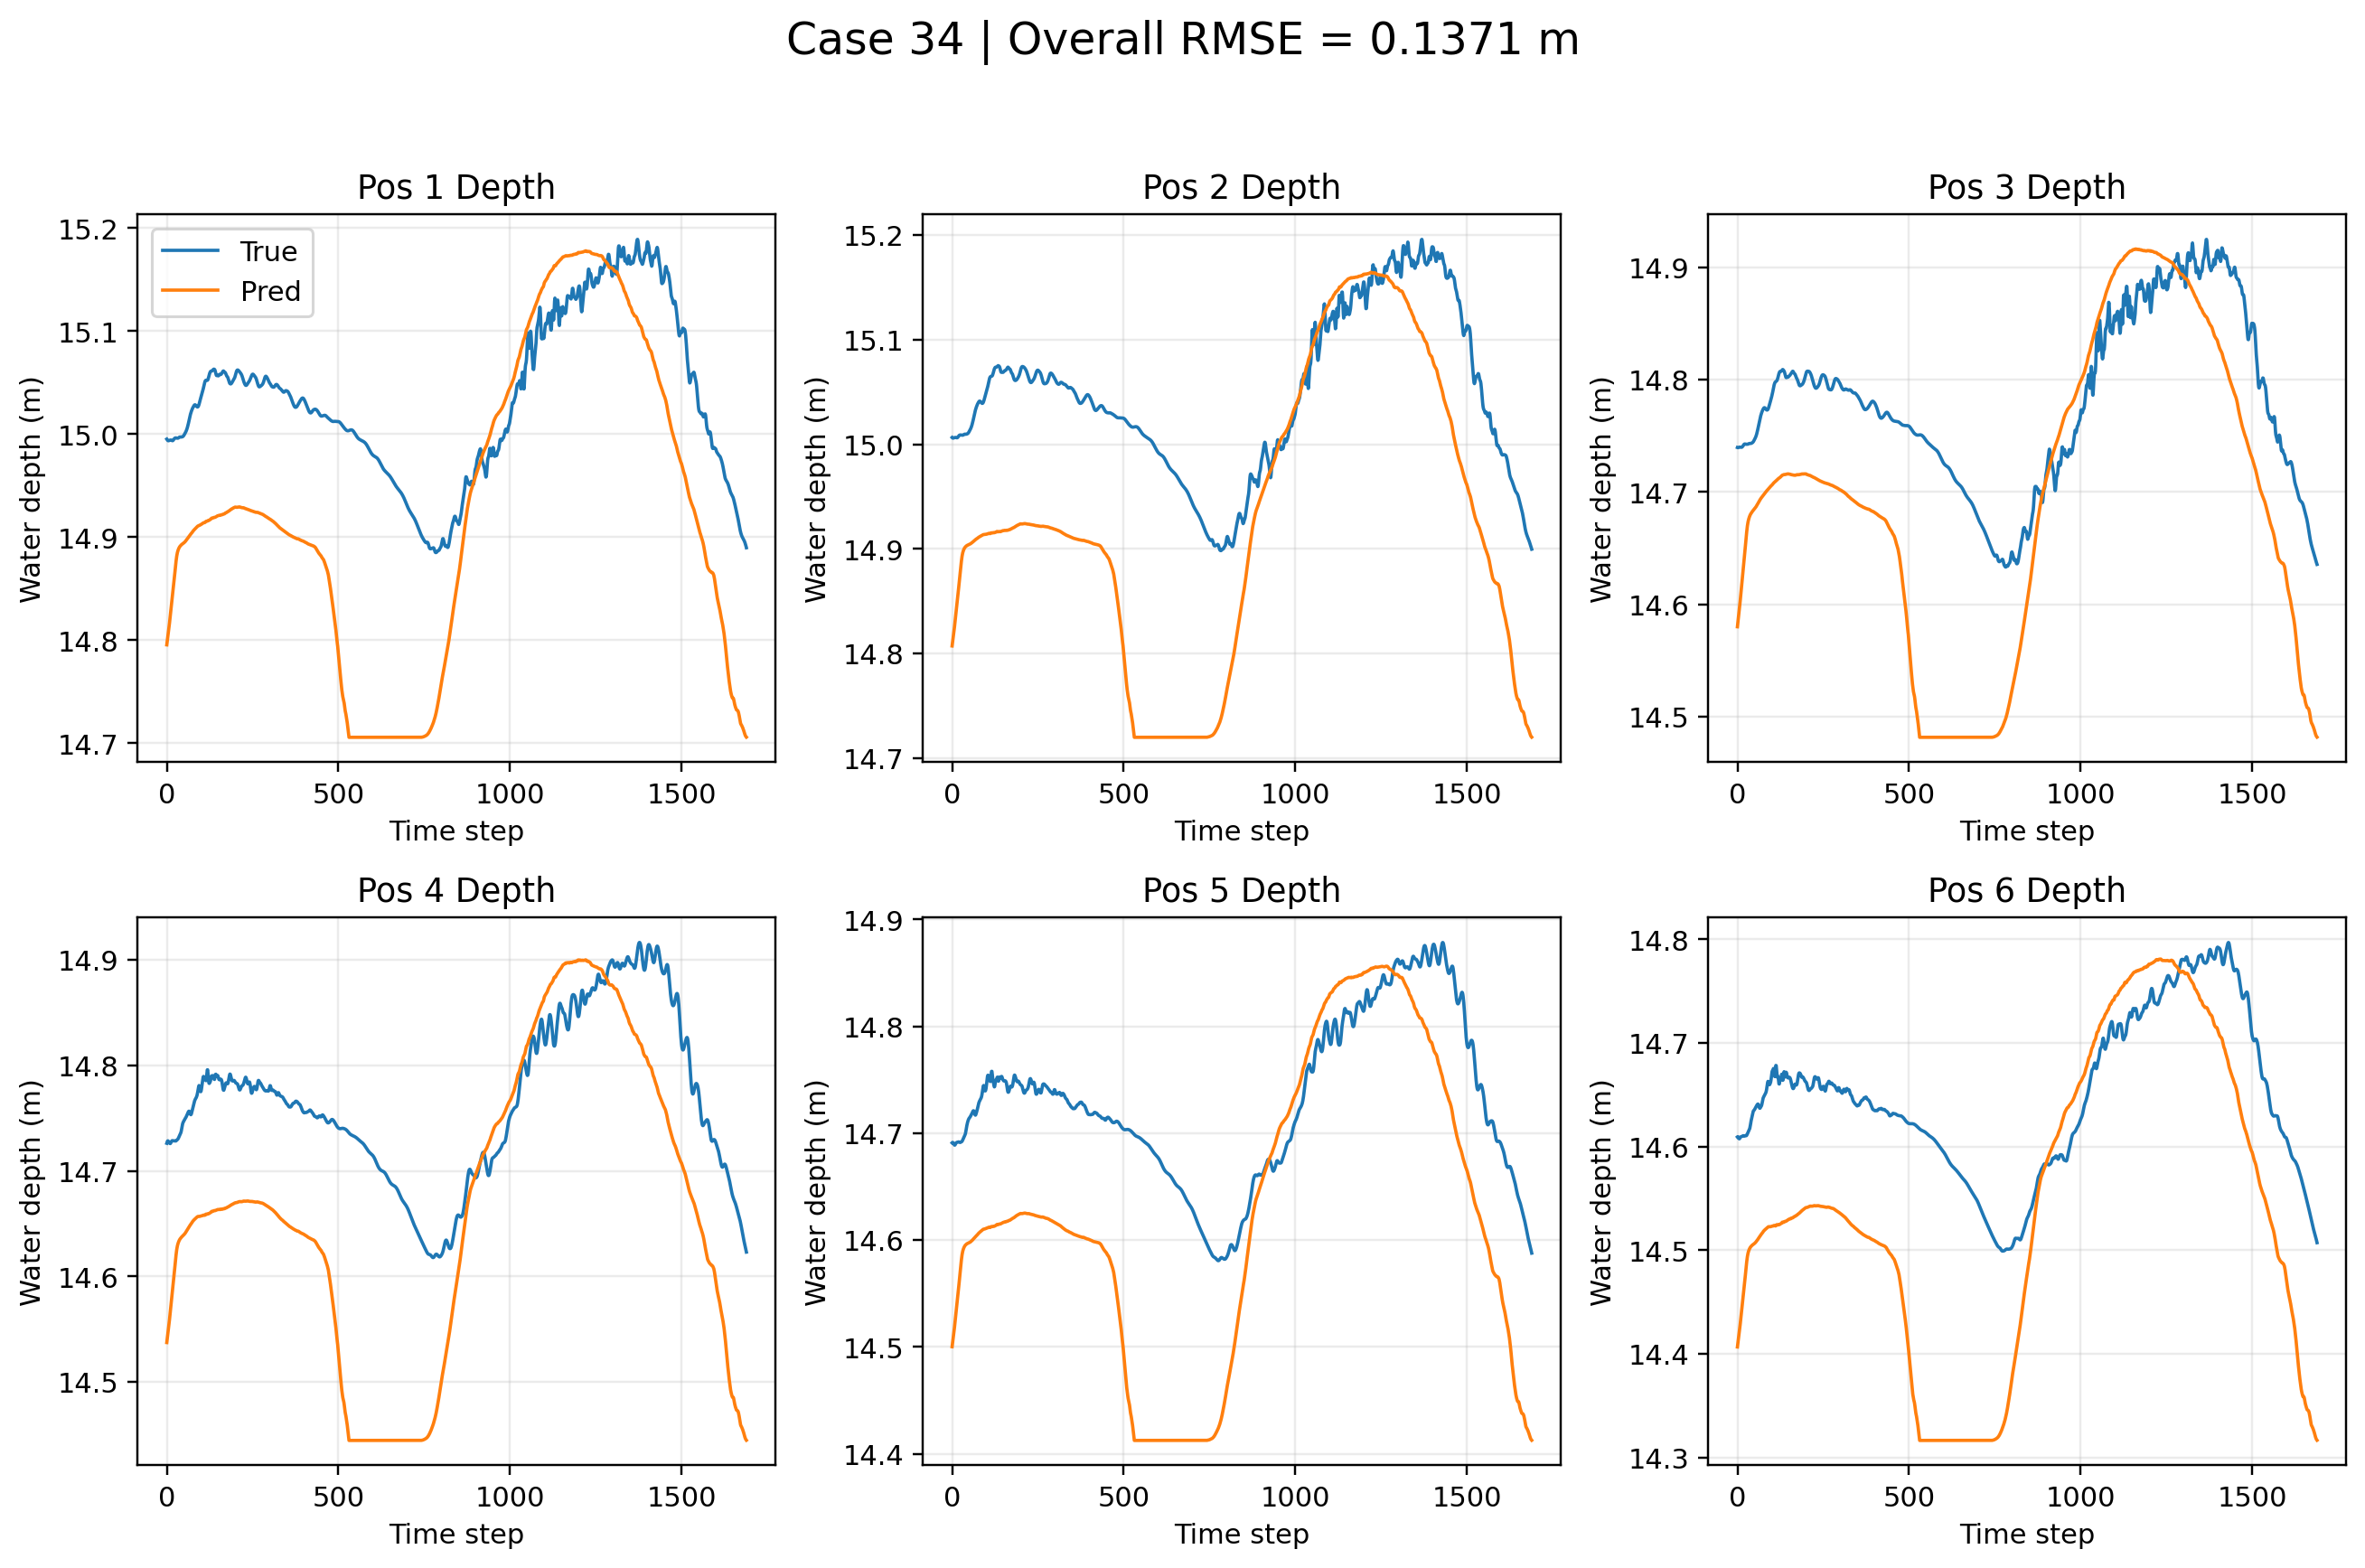

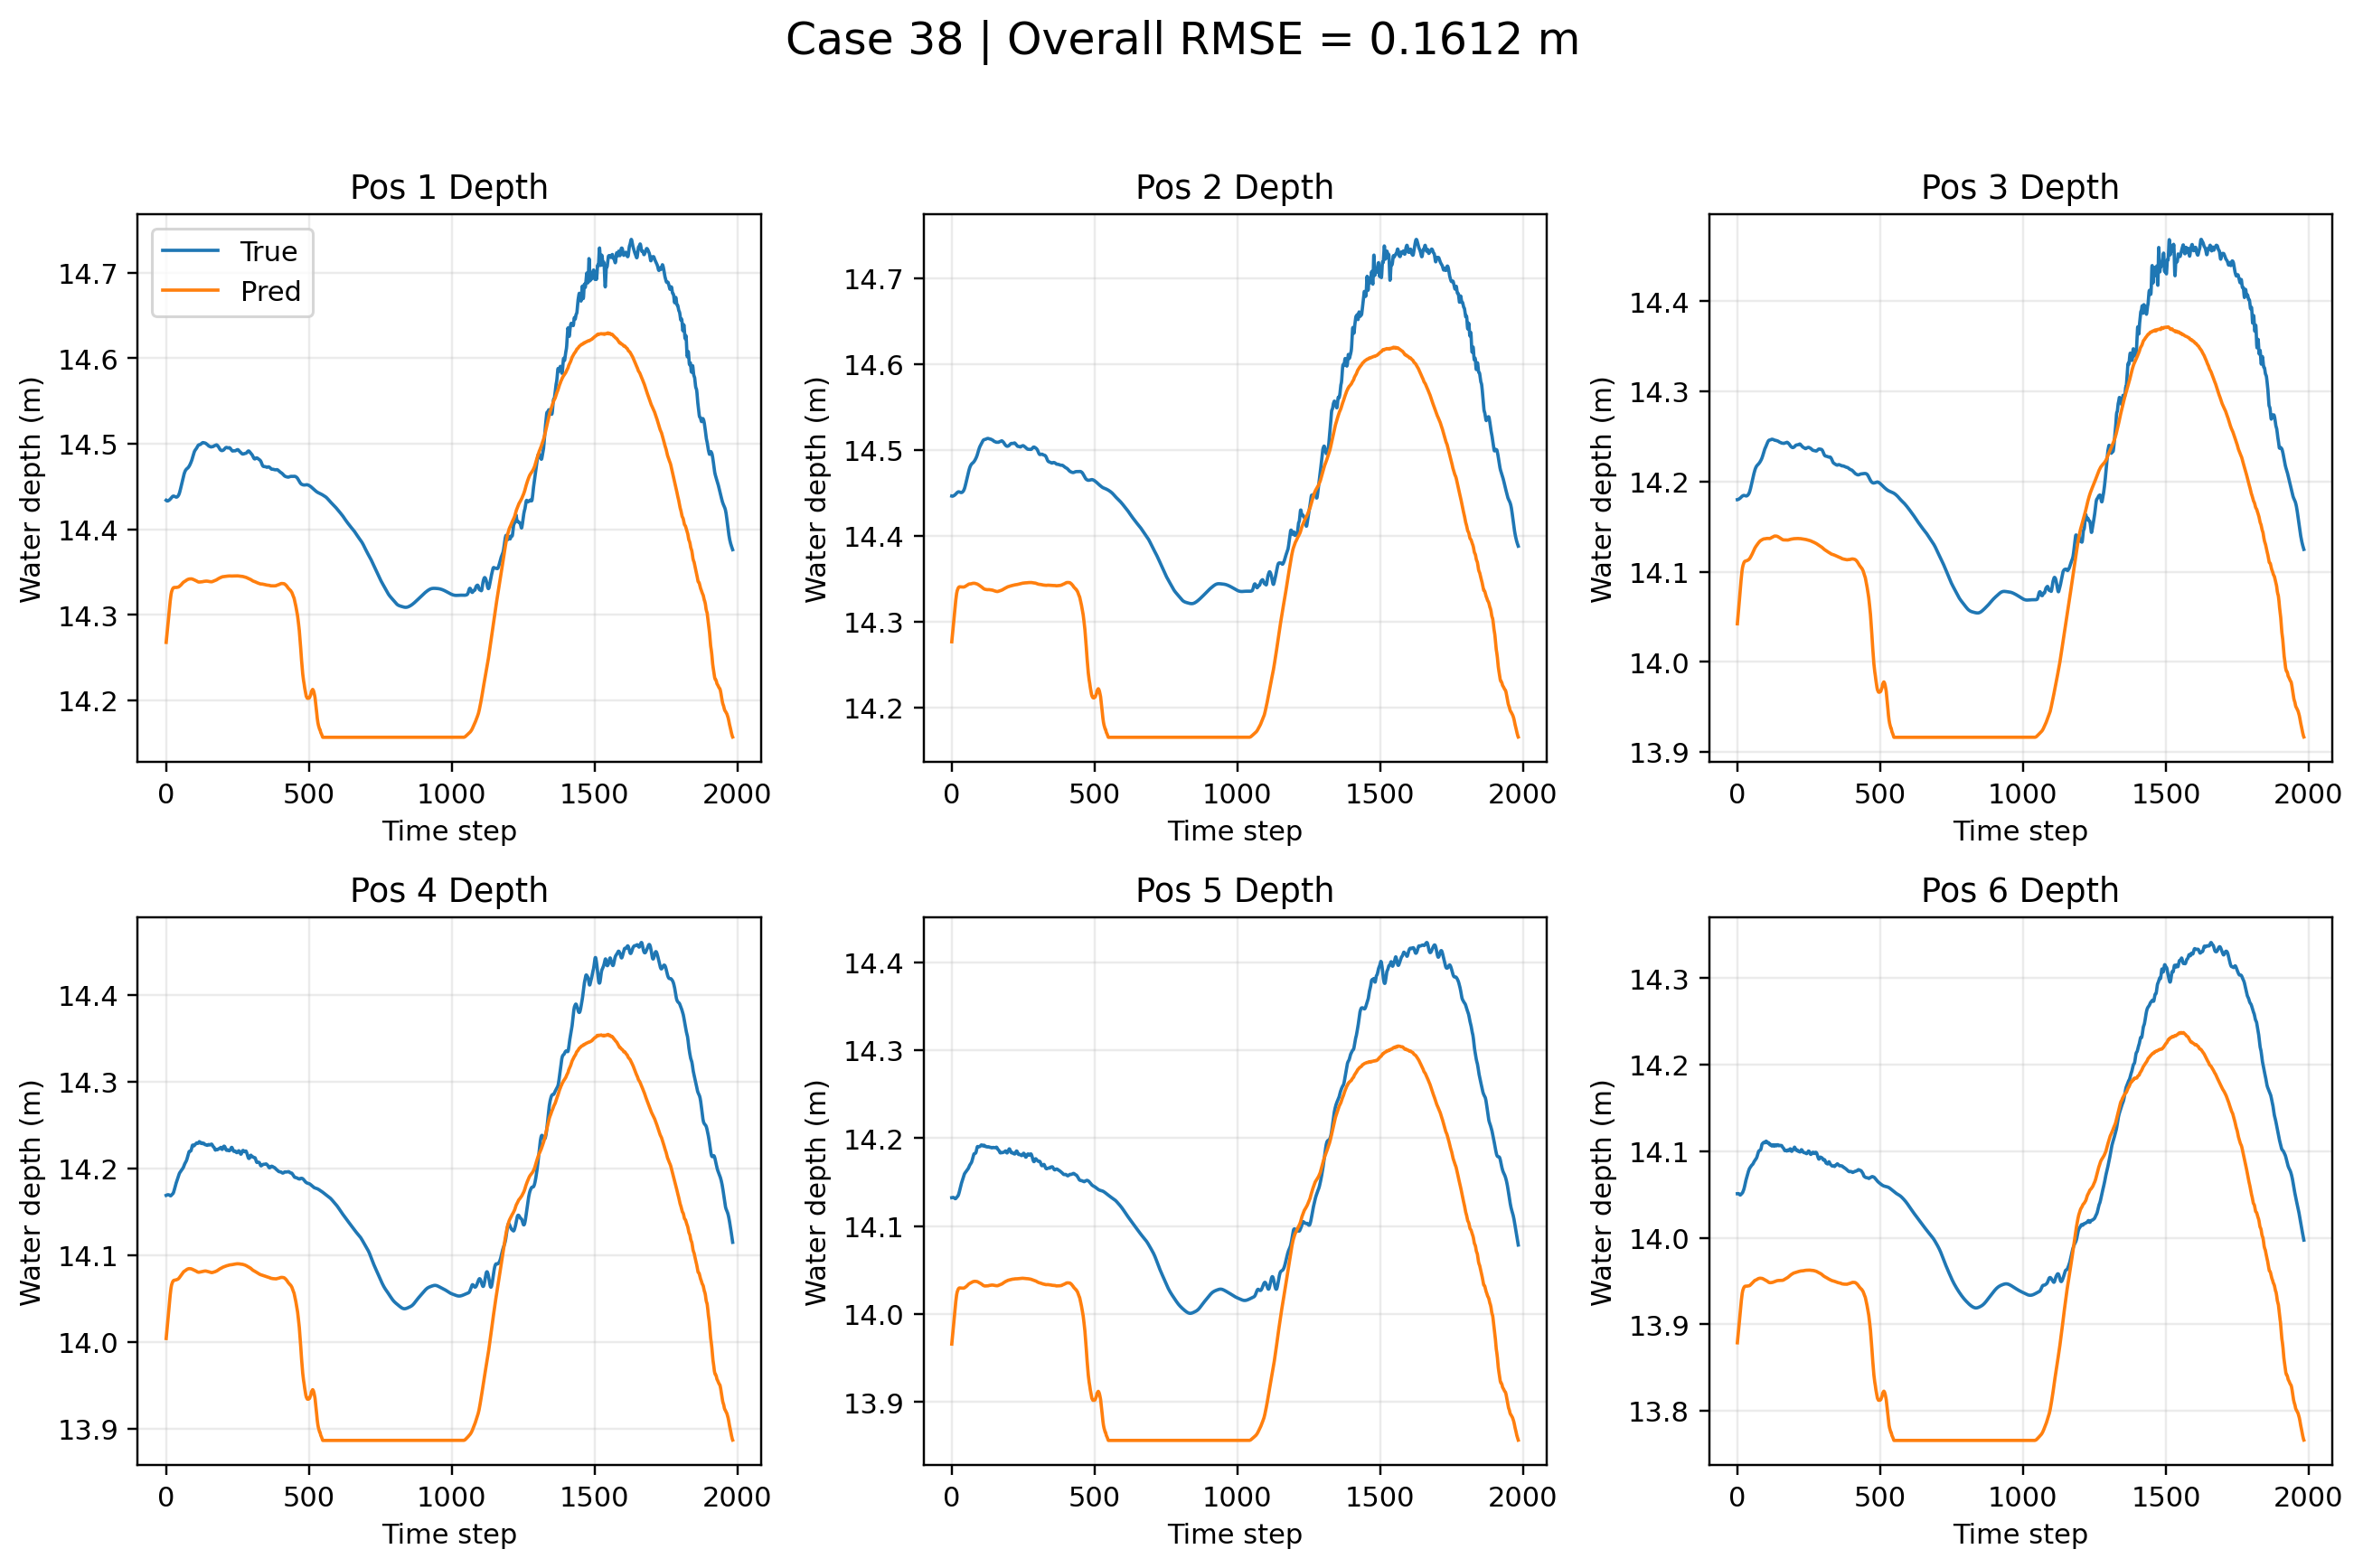

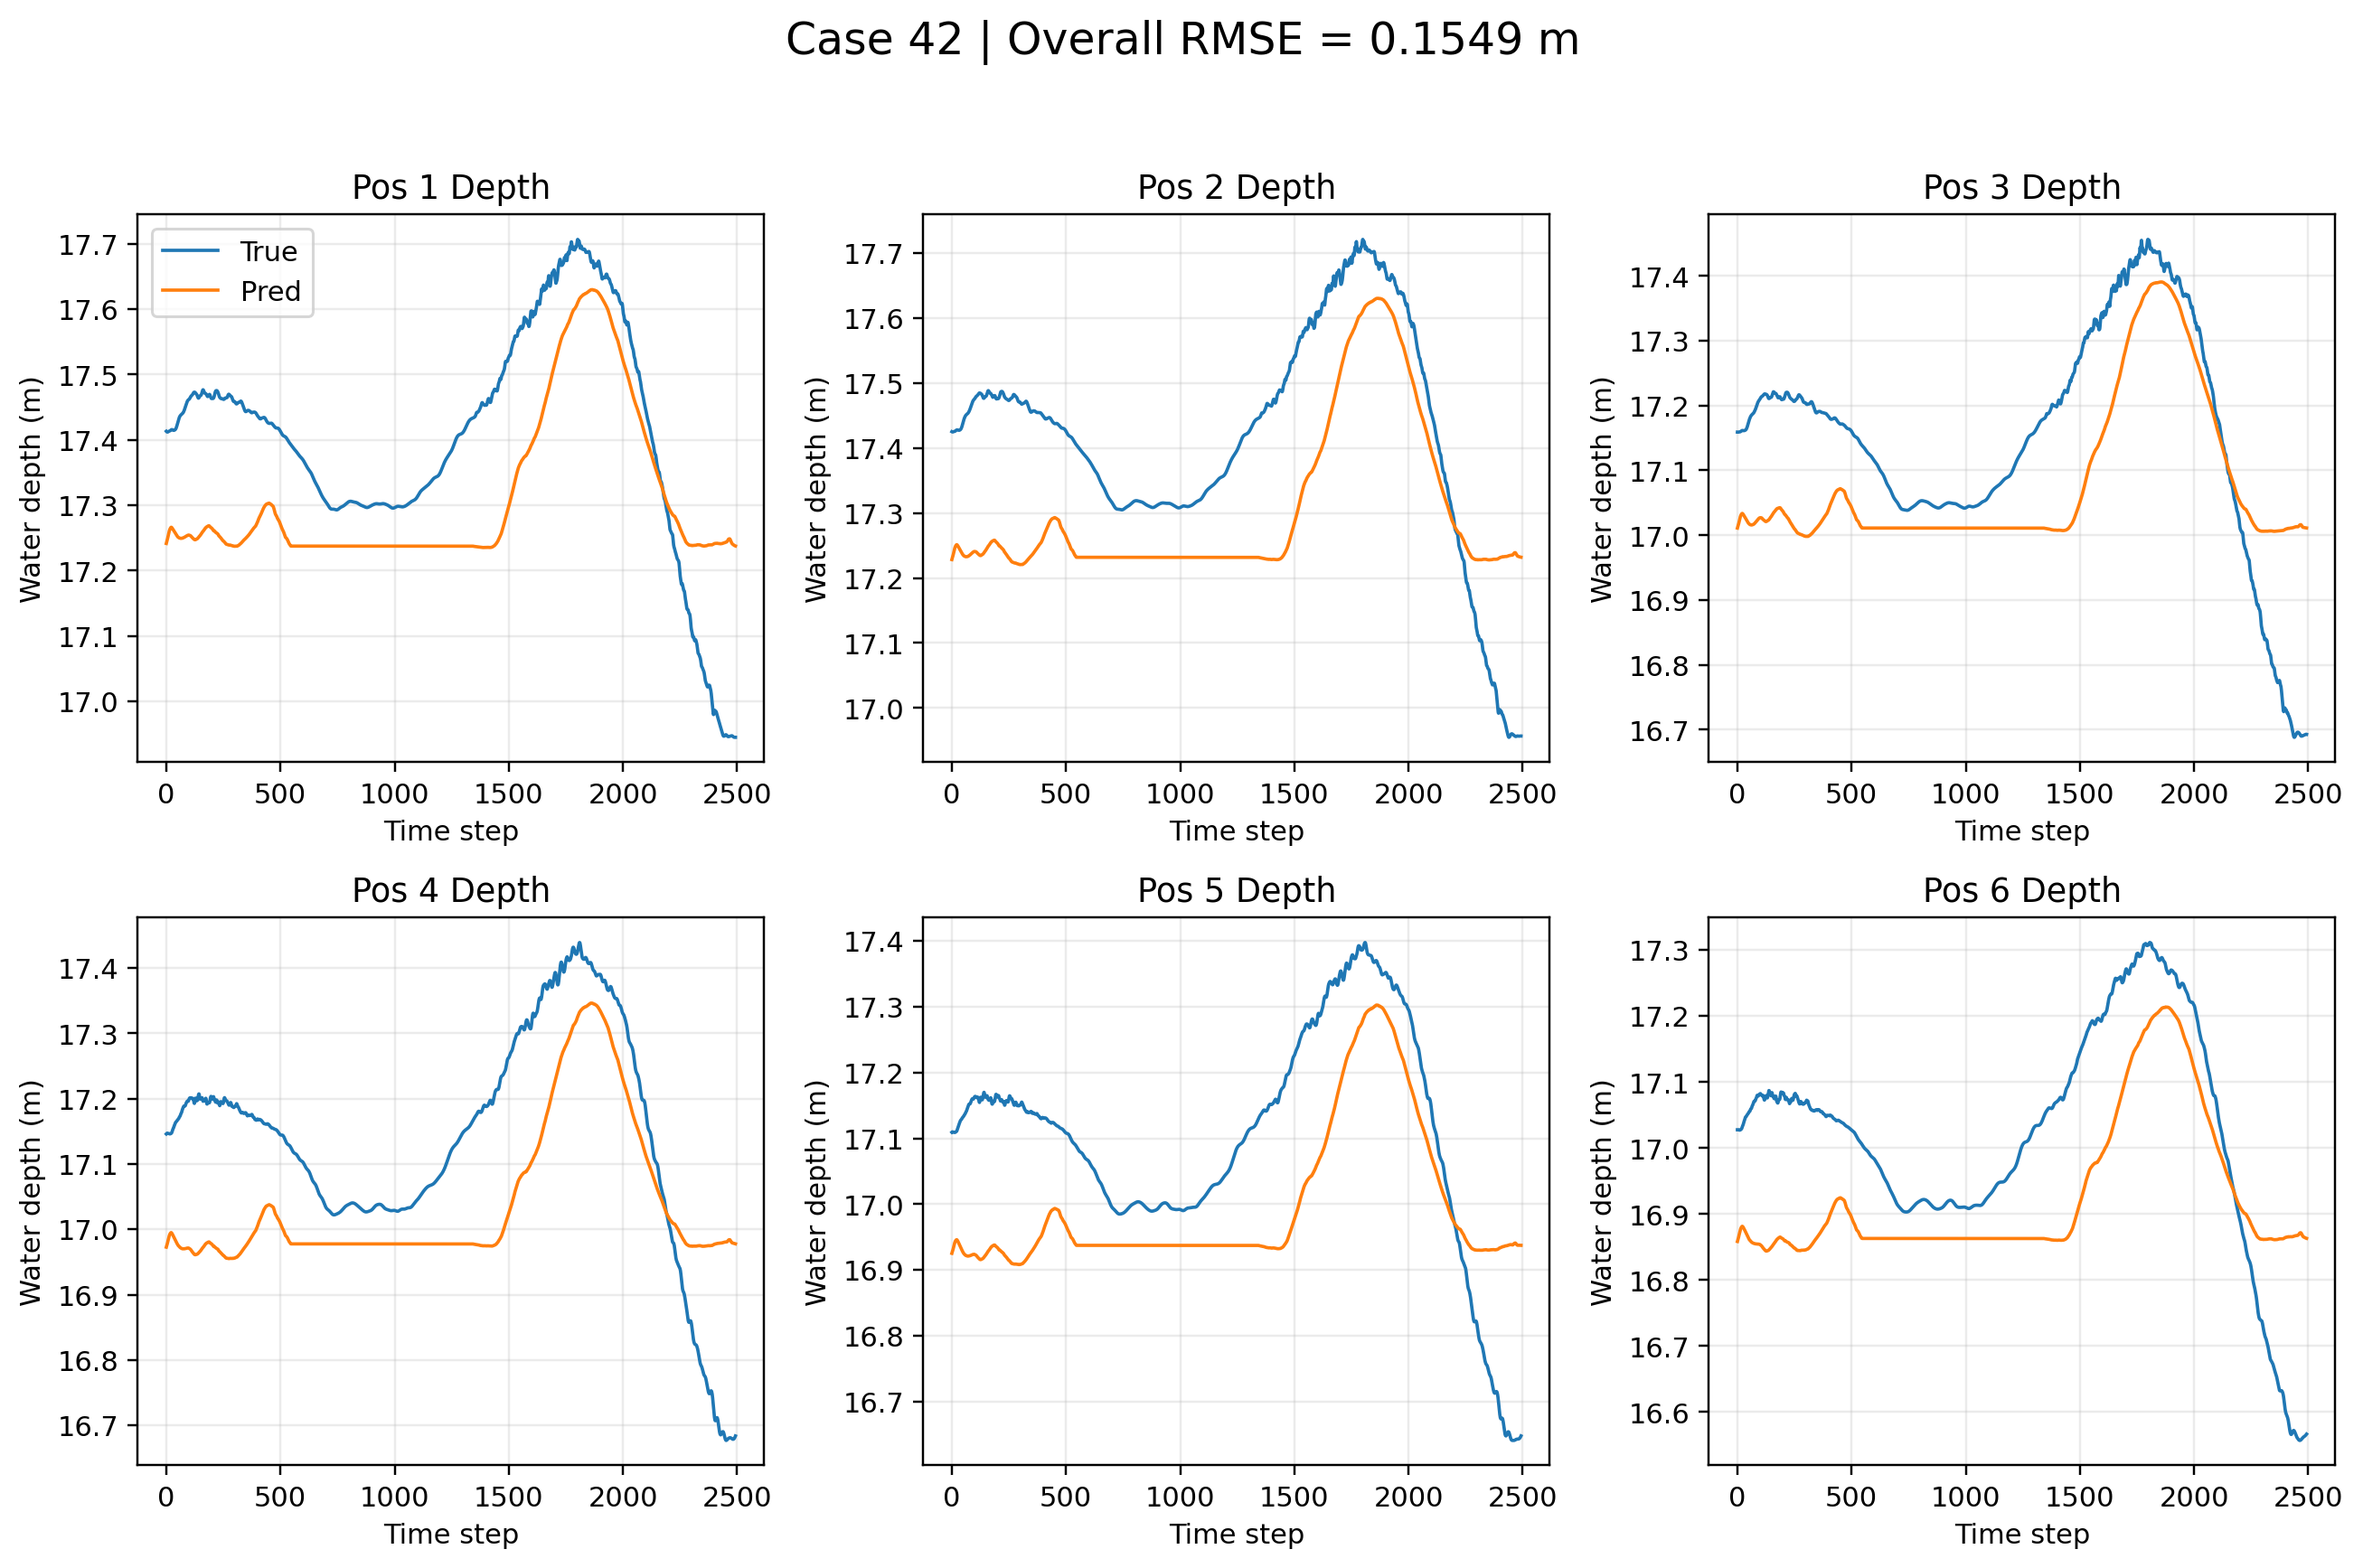

In [8]:
import matplotlib.pyplot as plt
import numpy as np

pos_names = [f"Pos {i}" for i in range(1, 7)]

for cid in sorted(test_data_per_case_norm.keys()):
    X_seq_case_norm, Y_case_norm = test_data_per_case_norm[cid]

    y_pred_case_norm = predict_norm(best_model, X_seq_case_norm, device)

    y_pred_case_real = denorm_y(y_pred_case_norm, Y_min, Y_max) 
    y_true_case_real = denorm_y(Y_case_norm, Y_min, Y_max)       

    rmse_case = float(np.sqrt(np.mean((y_pred_case_real - y_true_case_real) ** 2)))

    t = np.arange(y_true_case_real.shape[0])

    fig, axes = plt.subplots(
        2, 3,
        figsize=(12, 8),   
        dpi=220           
    )
    axes = axes.ravel()

    fig.suptitle(f"Case {cid} | Overall RMSE = {rmse_case:.4f} m", fontsize=16)

    for i in range(6):
        ax = axes[i]
        ax.plot(t, y_true_case_real[:, i], label="True", linewidth=1.2)
        ax.plot(t, y_pred_case_real[:, i], label="Pred", linewidth=1.2)

        ax.set_title(f"{pos_names[i]} Depth")
        ax.set_xlabel("Time step")
        ax.set_ylabel("Water depth (m)")
        ax.grid(True, alpha=0.25)

        if i == 0:
            ax.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])  
    plt.show()
